# The impact of molecular profiling of gliomas on diagnostics and prognosis
Gliomas are a diverse group of primary brain tumors originating from glial cells (astrocytes, oligodendrocytes, and ependymal cells) in the central nervous system. Starting from 2016 WHO classification of CNS tumors and its revisions shifted the focus from purely histopathological analysis to an integrated diagnosis incorporating molecular markers. By integrating molecular markers into the diagnostic framework, clinicians can better stratify patients, tailor treatment plans, and predict clinical outcomes. This shift towards personalized medicine, based on well-established molecular data, is improving the management and treatment of gliomas, particularly in identifying patients who may benefit from specific therapies or have better prognoses. 

## Load libraries and data

In [6]:
# Installation of necessary libraries
import sys

# Install required libraries
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install statsmodels
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install lifelines
!{sys.executable} -m pip install gseapy
!{sys.executable} -m pip install scikit-learn==1.5.2
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install umap-learn
!{sys.executable} -m pip install scikit-survival

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [6]:
!{sys.executable} -m pip install ipywidgets --upgrade

Defaulting to user installation because normal site-packages is not writeable


In [7]:
# import libraries to use
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import datasets, model_selection, metrics
import math
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import umap
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score, davies_bouldin_score, RocCurveDisplay, precision_score, accuracy_score, roc_auc_score, f1_score, classification_report, confusion_matrix, make_scorer
from sklearn.model_selection import StratifiedKFold,cross_val_score, cross_val_predict
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.inspection import permutation_importance
from lifelines import CoxPHFitter
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sksurv.util import Surv
from sklearn.inspection import permutation_importance

## Data formatting and processing

### Merging two tables from public repository

We have 2 tables with data: clinical data and sequencing results for glioma patients. We will start with primary description of the patiens cohort from the clinical data, then look at the sequencing results and only keep missence or nonsence mutations for simplicity.

In [8]:
import os
print(os.getcwd())

/Users/glusker/Documents/courses/CAS_ADS/Module3/Glioma_ML


In [9]:
# Load the CSV files
data_mutations_short = pd.read_csv('data_mutations_short.csv', sep=",")
clinical_data = pd.read_csv('lgggbm_tcga_pub_clinical_data_short.csv', sep=",")

# Display the first few rows
print(data_mutations_short.head())
print(clinical_data.head())

  Hugo_Symbol Variant_Classification Tumor_Sample_Barcode
0       AKAP6      Missense_Mutation         TCGA-02-0003
1      ANAPC4      Missense_Mutation         TCGA-02-0003
2       AUTS2      Missense_Mutation         TCGA-02-0003
3       ABTB3      Missense_Mutation         TCGA-02-0003
4      CLEC3B                 Silent         TCGA-02-0003
     Patient ID        Sample ID  Absolute Extract Ploidy  Diagnosis Age  \
0  TCGA-02-0001  TCGA-02-0001-01                     3.47             44   
1  TCGA-02-0003  TCGA-02-0003-01                     1.96             50   
2  TCGA-02-0004  TCGA-02-0004-01                      NaN             59   
3  TCGA-02-0006  TCGA-02-0006-01                     1.93             56   
4  TCGA-02-0007  TCGA-02-0007-01                     1.89             40   

  ATRX status BCR Status BRAF-KIAA1549 fusion BRAF V600E status Cancer Type  \
0         NaN        IGC                  NaN               NaN      Glioma   
1          WT        IGC             

In [10]:
# Step 1: Standardize formatting by stripping whitespace and converting to uppercase
data_mutations_short['Tumor_Sample_Barcode'] = data_mutations_short['Tumor_Sample_Barcode'].str.strip().str.upper()
clinical_data['Sample ID'] = clinical_data['Sample ID'].str.strip().str.upper()
clinical_data['Patient ID'] = clinical_data['Patient ID'].str.strip().str.upper()

**Primary description of the dataset**

We want to see the primary characteristics of the cohort: male/female distribution, age distribution, diagnoses. 

Total Patient Count: 1047

Sex Distribution:
Sex
Male      618
Female    429
Name: count, dtype: int64


/var/folders/tn/yx1ylmyx7n9ccd0yfynwzmr80000gq/T/ipykernel_27378/3328182810.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sex_distribution.index, y=sex_distribution.values, palette='pastel')


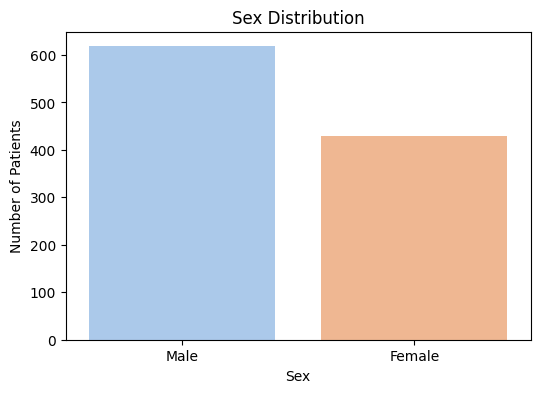

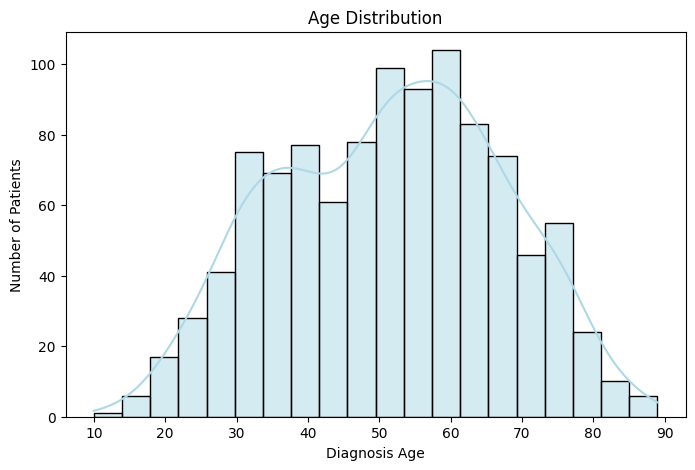


Neoplasm Histologic Type Distribution:
Neoplasm Histologic Type Name
glioblastoma         590
oligodendroglioma    174
astrocytoma          169
oligoastrocytoma     114
Name: count, dtype: int64


/var/folders/tn/yx1ylmyx7n9ccd0yfynwzmr80000gq/T/ipykernel_27378/3328182810.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=histologic_type_distribution.index, y=histologic_type_distribution.values, palette='muted')


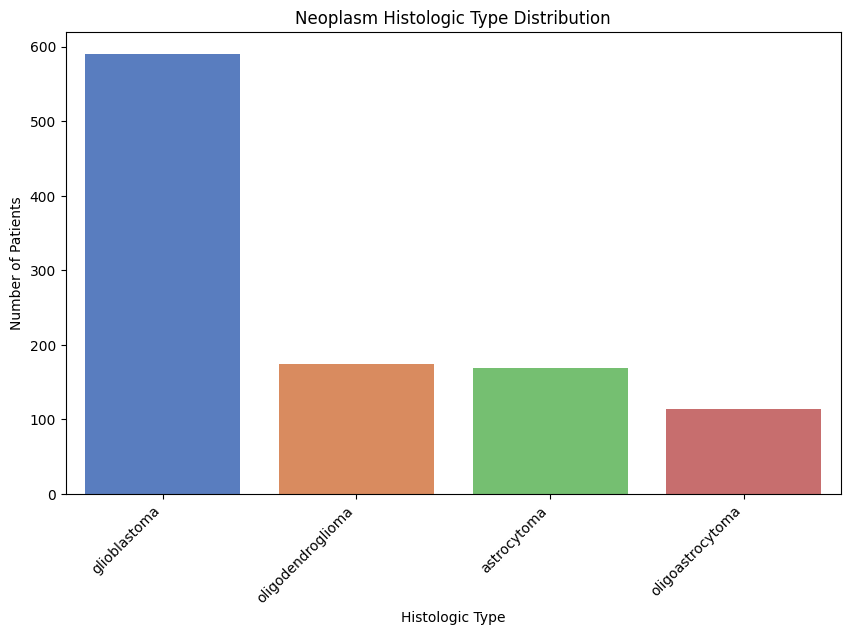


Neoplasm Histologic Grade Distribution:
Neoplasm Histologic Grade
G4    590
G3    241
G2    216
Name: count, dtype: int64


/var/folders/tn/yx1ylmyx7n9ccd0yfynwzmr80000gq/T/ipykernel_27378/3328182810.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=histologic_grade_distribution.index, y=histologic_grade_distribution.values, palette='deep')


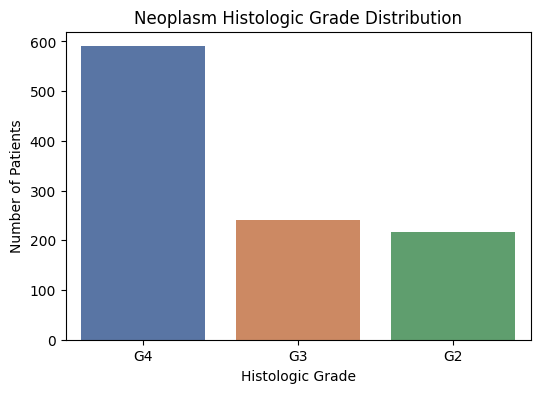

In [11]:
# Display total patient count
total_patients = clinical_data['Patient ID'].nunique()
print(f"Total Patient Count: {total_patients}")

# Plot and display Sex distribution
sex_distribution = clinical_data['Sex'].value_counts()
print("\nSex Distribution:")
print(sex_distribution)

plt.figure(figsize=(6, 4))
sns.barplot(x=sex_distribution.index, y=sex_distribution.values, palette='pastel')
plt.title('Sex Distribution')
plt.xlabel('Sex')
plt.ylabel('Number of Patients')
plt.show()

# Plot and display Age distribution
plt.figure(figsize=(8, 5))
sns.histplot(clinical_data['Diagnosis Age'], bins=20, kde=True, color='lightblue')
plt.title('Age Distribution')
plt.xlabel('Diagnosis Age')
plt.ylabel('Number of Patients')
plt.show()

# Display Neoplasm Histologic Type distribution
histologic_type_distribution = clinical_data['Neoplasm Histologic Type Name'].value_counts()
print("\nNeoplasm Histologic Type Distribution:")
print(histologic_type_distribution)

plt.figure(figsize=(10, 6))
sns.barplot(x=histologic_type_distribution.index, y=histologic_type_distribution.values, palette='muted')
plt.xticks(rotation=45, ha='right')
plt.title('Neoplasm Histologic Type Distribution')
plt.xlabel('Histologic Type')
plt.ylabel('Number of Patients')
plt.show()

# Display Neoplasm Histologic Grade distribution
histologic_grade_distribution = clinical_data['Neoplasm Histologic Grade'].value_counts()
print("\nNeoplasm Histologic Grade Distribution:")
print(histologic_grade_distribution)

plt.figure(figsize=(6, 4))
sns.barplot(x=histologic_grade_distribution.index, y=histologic_grade_distribution.values, palette='deep')
plt.title('Neoplasm Histologic Grade Distribution')
plt.xlabel('Histologic Grade')
plt.ylabel('Number of Patients')
plt.show()

Here we see that most of our patients have G4 glioblastoma (more than half of the cohort), there are slightly more males than females, and age seems to be more or less normally distributed.

**Merging clinical data table with mutated genes table**

Creating mutations_merged_df: merging clinical data table with mutated genes table using Patient ID and Sample ID as merging columns. As it often happens in clinical research, there are some samples that don't match IDs, and we are losing a bit more than 2000 rows in the clinical data table. Then we want to only keep mutations that affect protein function. For simplicity, we will only focus on point mutations and drop silent mutations (that don't influence amino acid sequencr of the protein).

In [12]:
# Step 1: Perform the merging steps to create the intermediate columns
merged_df = pd.merge(data_mutations_short, clinical_data[['Patient ID', 'Sample ID']],
                     left_on='Tumor_Sample_Barcode', right_on='Sample ID', how='left')

merged_df = pd.merge(merged_df, clinical_data[['Patient ID', 'Sample ID']],
                     left_on='Tumor_Sample_Barcode', right_on='Patient ID', how='left',
                     suffixes=('_from_sample', '_from_patient'))

# Step 2: Finalize columns, rename, and calculate row counts

# Save the initial row count before dropping NaN values
initial_row_count = merged_df.shape[0]

# Finalize Patient ID and Sample ID columns based on available matches
merged_df['Patient ID'] = merged_df['Patient ID_from_sample'].combine_first(merged_df['Patient ID_from_patient'])
merged_df['Sample ID'] = merged_df['Sample ID_from_sample'].combine_first(merged_df['Sample ID_from_patient'])

# Drop rows with NaN values in the final Patient ID and Sample ID columns
merged_df = merged_df.dropna(subset=['Patient ID', 'Sample ID'])

# Save the row count after dropping NaN values
final_row_count = merged_df.shape[0]

# Drop intermediate columns used for matching
mutations_merged_df = merged_df.drop(columns=['Patient ID_from_sample', 'Patient ID_from_patient',
                                    'Sample ID_from_sample', 'Sample ID_from_patient'])

# Display the result for verification
print(f"Initial row count before dropping NaN: {initial_row_count}")
print(f"Final row count after dropping NaN: {final_row_count}")

print("Columns in the merged DataFrame:")
print(mutations_merged_df.columns)
print("First few rows of the merged DataFrame:")
print(mutations_merged_df.head())


Initial row count before dropping NaN: 30729
Final row count after dropping NaN: 28613
Columns in the merged DataFrame:
Index(['Hugo_Symbol', 'Variant_Classification', 'Tumor_Sample_Barcode',
       'Patient ID', 'Sample ID'],
      dtype='object')
First few rows of the merged DataFrame:
  Hugo_Symbol Variant_Classification Tumor_Sample_Barcode    Patient ID  \
0       AKAP6      Missense_Mutation         TCGA-02-0003  TCGA-02-0003   
1      ANAPC4      Missense_Mutation         TCGA-02-0003  TCGA-02-0003   
2       AUTS2      Missense_Mutation         TCGA-02-0003  TCGA-02-0003   
3       ABTB3      Missense_Mutation         TCGA-02-0003  TCGA-02-0003   
4      CLEC3B                 Silent         TCGA-02-0003  TCGA-02-0003   

         Sample ID  
0  TCGA-02-0003-01  
1  TCGA-02-0003-01  
2  TCGA-02-0003-01  
3  TCGA-02-0003-01  
4  TCGA-02-0003-01  


In [13]:
# Row count before filtering
initial_row_count = mutations_merged_df.shape[0]

# Filter out rows where Variant_Classification is 'Silent'
mutations_merged_df = mutations_merged_df[mutations_merged_df['Variant_Classification'] != 'Silent']

# Row count after filtering
final_row_count = mutations_merged_df.shape[0]

# Calculate the number of rows removed (those with 'Silent' in Variant_Classification)
silent_count = initial_row_count - final_row_count

# Display the results
print(f"Initial row count: {initial_row_count}")
print(f"Number of rows with 'Silent' in Variant_Classification removed: {silent_count}")
print(f"Row count after dropping 'Silent' rows: {final_row_count}")

# Display the updated DataFrame for verification
print("Updated mutations_merged_df:")
print(mutations_merged_df.head())


Initial row count: 28613
Number of rows with 'Silent' in Variant_Classification removed: 6884
Row count after dropping 'Silent' rows: 21729
Updated mutations_merged_df:
  Hugo_Symbol Variant_Classification Tumor_Sample_Barcode    Patient ID  \
0       AKAP6      Missense_Mutation         TCGA-02-0003  TCGA-02-0003   
1      ANAPC4      Missense_Mutation         TCGA-02-0003  TCGA-02-0003   
2       AUTS2      Missense_Mutation         TCGA-02-0003  TCGA-02-0003   
3       ABTB3      Missense_Mutation         TCGA-02-0003  TCGA-02-0003   
7      DZIP1L      Missense_Mutation         TCGA-02-0003  TCGA-02-0003   

         Sample ID  
0  TCGA-02-0003-01  
1  TCGA-02-0003-01  
2  TCGA-02-0003-01  
3  TCGA-02-0003-01  
7  TCGA-02-0003-01  


**Selecting 20 most frequently mutated genes**

As computational load increases with the number of features, we want to focus on 20 most frequently mutated genes in our dataset. These genes are more likely to be involved in tumor development and progression, as frequent mutations often highlight critical pathways and oncogenes or tumor suppressors. 

Total number of unique patients: 745
Number of patients without mutations in any of the top 20 genes: 76


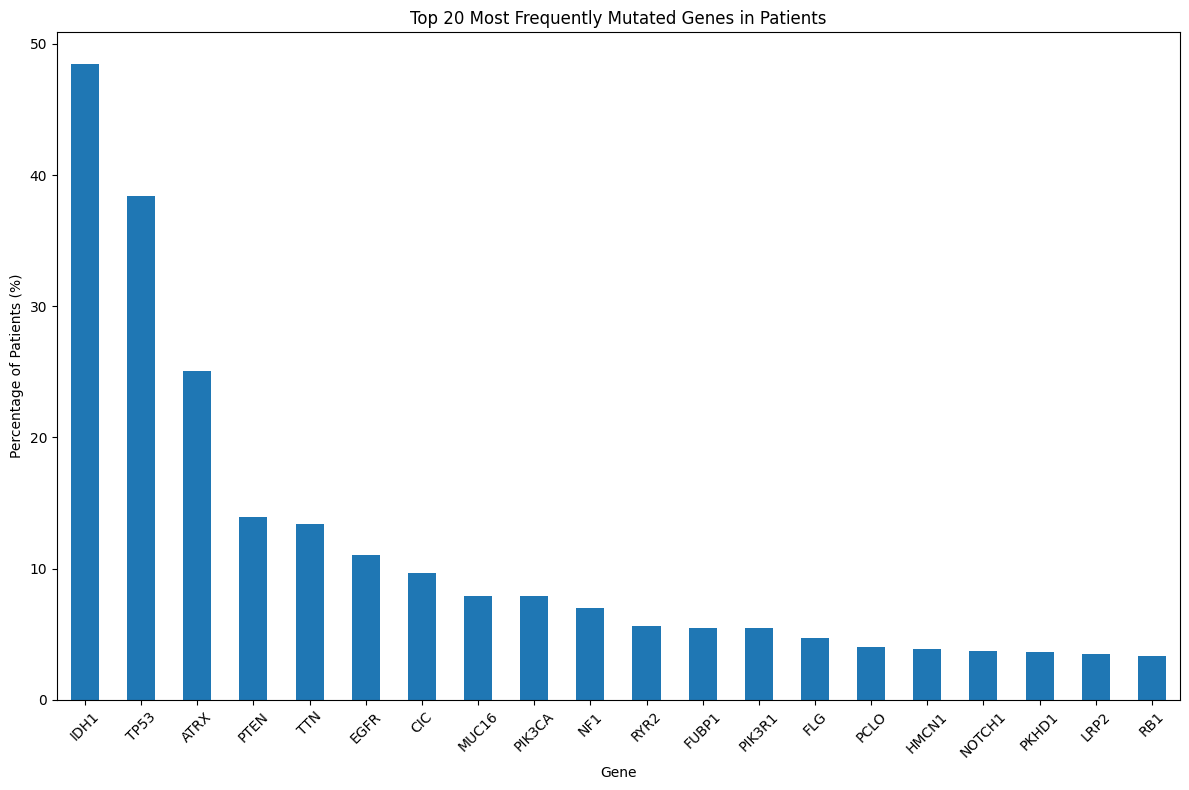

In [14]:
# Step 1: Count unique patients for each gene
gene_patient_counts = mutations_merged_df.groupby('Hugo_Symbol')['Patient ID'].nunique()

# Step 2: Calculate the percentage of patients with mutations in each gene
total_unique_patients = mutations_merged_df['Patient ID'].nunique()
gene_patient_percentages = (gene_patient_counts / total_unique_patients) * 100

# Step 3: Select the top 30 most frequently mutated genes
top_20_genes = gene_patient_percentages.nlargest(20).index

# Step 4: Identify unique patients who have mutations in any of the top 20 genes
patients_with_top_20_genes = mutations_merged_df[mutations_merged_df['Hugo_Symbol'].isin(top_20_genes)]['Patient ID'].unique()
unique_patients_with_top_20_genes = len(set(patients_with_top_20_genes))

# Step 5: Calculate the number of patients without mutations in any of the top 20 genes
patients_without_top_20_genes = total_unique_patients - unique_patients_with_top_20_genes

# Display results
print(f"Total number of unique patients: {total_unique_patients}")
print(f"Number of patients without mutations in any of the top 20 genes: {patients_without_top_20_genes}")

# Step 6: Plotting the top 20 genes by percentage of patients with mutations
top_20_percentages = gene_patient_percentages[top_20_genes]

plt.figure(figsize=(12, 8))
top_20_percentages.plot(kind='bar')
plt.xlabel("Gene")
plt.ylabel("Percentage of Patients (%)")
plt.title("Top 20 Most Frequently Mutated Genes in Patients")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


We chose top 20 genes as features, now we are going to add 'Diagnosis Age', 'Sex', 'TMB (nonsynonymous)', 'Pan-Glioma DNA Methylation Cluster', 'Neoplasm Histologic Type Name', 'Neoplasm Histologic Grade' for clustering analysis

In [15]:
# Step 2: Filter mutations_merged_df to include only rows with the top 20 genes, while retaining all patients
top_20_mutations_df = mutations_merged_df[mutations_merged_df['Hugo_Symbol'].isin(top_20_genes)]
all_patients_df = mutations_merged_df[['Patient ID']].drop_duplicates()
top_20_encoded_df = all_patients_df.merge(top_20_mutations_df, on='Patient ID', how='left')

# Step 3: One-hot encode the presence of each of the top 20 genes for all patients
for gene in top_20_genes:
    top_20_encoded_df[gene] = (top_20_encoded_df['Hugo_Symbol'] == gene).astype(int)

# Step 4: Remove columns not needed for analysis
top_20_encoded_df = top_20_encoded_df.drop(columns=['Hugo_Symbol', 'Variant_Classification', 'Tumor_Sample_Barcode'])

# Display the resulting DataFrame for verification
print("Top 20 one-hot encoded DataFrame with all patients retained:")
print(top_20_encoded_df.head())


Top 20 one-hot encoded DataFrame with all patients retained:
     Patient ID        Sample ID  IDH1  TP53  ATRX  PTEN  TTN  EGFR  CIC  \
0  TCGA-02-0003  TCGA-02-0003-01     0     0     0     0    0     1    0   
1  TCGA-02-0003  TCGA-02-0003-01     0     0     0     0    0     0    0   
2  TCGA-02-0003  TCGA-02-0003-01     0     1     0     0    0     0    0   
3  TCGA-02-0003  TCGA-02-0003-01     0     1     0     0    0     0    0   
4  TCGA-02-0033  TCGA-02-0033-01     0     0     0     0    0     0    0   

   MUC16  ...  RYR2  FUBP1  PIK3R1  FLG  PCLO  HMCN1  NOTCH1  PKHD1  LRP2  RB1  
0      0  ...     0      0       0    0     0      0       0      0     0    0  
1      0  ...     0      0       1    0     0      0       0      0     0    0  
2      0  ...     0      0       0    0     0      0       0      0     0    0  
3      0  ...     0      0       0    0     0      0       0      0     0    0  
4      0  ...     0      0       0    0     0      0       0      0     0    

In [16]:
# Save the cleaned DataFrame
top_20_encoded_df.to_csv('top_20_encoded_df.csv', index=False)

In [17]:
# Select relevant columns from clinical_data
clinical_columns = ['Patient ID', 'Diagnosis Age', 'Sex', 'TMB (nonsynonymous)', 'Pan-Glioma DNA Methylation Cluster', 'Neoplasm Histologic Type Name', 'Neoplasm Histologic Grade']
clinical_selected = clinical_data[clinical_columns]

# Merge the selected clinical columns with top_20_encoded_df on 'Patient ID'
merged_top_20_df = pd.merge(top_20_encoded_df, clinical_selected, on='Patient ID', how='left')

# Display the resulting DataFrame for verification
print("Merged DataFrame with top 20 encoded genes and selected clinical data:")
print(merged_top_20_df.head())


Merged DataFrame with top 20 encoded genes and selected clinical data:
     Patient ID        Sample ID  IDH1  TP53  ATRX  PTEN  TTN  EGFR  CIC  \
0  TCGA-02-0003  TCGA-02-0003-01     0     0     0     0    0     1    0   
1  TCGA-02-0003  TCGA-02-0003-01     0     0     0     0    0     0    0   
2  TCGA-02-0003  TCGA-02-0003-01     0     1     0     0    0     0    0   
3  TCGA-02-0003  TCGA-02-0003-01     0     1     0     0    0     0    0   
4  TCGA-02-0033  TCGA-02-0033-01     0     0     0     0    0     0    0   

   MUC16  ...  NOTCH1  PKHD1  LRP2  RB1  Diagnosis Age   Sex  \
0      0  ...       0      0     0    0             50  Male   
1      0  ...       0      0     0    0             50  Male   
2      0  ...       0      0     0    0             50  Male   
3      0  ...       0      0     0    0             50  Male   
4      0  ...       0      0     0    0             54  Male   

   TMB (nonsynonymous)  Pan-Glioma DNA Methylation Cluster  \
0             1.366667   

In [18]:
# Df to go back to after clustering
merged_before_norm_df = merged_top_20_df.copy()

Check NaN values in the dataset after all the preprocessing done.

In [19]:
# Group by 'Patient ID' to get unique patient entries
unique_patients_df = merged_before_norm_df.groupby('Patient ID').first()

# Count NaNs in each column
nan_counts = unique_patients_df.isnull().sum()
print("Count of NaNs in each column:")
print(nan_counts)

# Display the unique patient count after grouping
total_unique_patients = unique_patients_df.shape[0]
print(f"\nTotal Unique Patient Count: {total_unique_patients}")

# Check unique counts in 'Sex' after grouping
sex_distribution = unique_patients_df['Sex'].value_counts()
print("\nSex Distribution:")
print(sex_distribution)


Count of NaNs in each column:
Sample ID                             76
IDH1                                   0
TP53                                   0
ATRX                                   0
PTEN                                   0
TTN                                    0
EGFR                                   0
CIC                                    0
MUC16                                  0
PIK3CA                                 0
NF1                                    0
RYR2                                   0
FUBP1                                  0
PIK3R1                                 0
FLG                                    0
PCLO                                   0
HMCN1                                  0
NOTCH1                                 0
PKHD1                                  0
LRP2                                   0
RB1                                    0
Diagnosis Age                          0
Sex                                    0
TMB (nonsynonymous)        

**Descriptive statistics on the final dataset**

Total Unique Patient Count: 696

Sex Distribution:
Sex
Male      405
Female    291
Name: count, dtype: int64

Age Distribution Statistics:
count    696.000000
mean      49.573276
std       15.909649
min       14.000000
25%       36.000000
50%       50.000000
75%       62.000000
max       89.000000
Name: Diagnosis Age, dtype: float64

Neoplasm Histologic Type Distribution:
Neoplasm Histologic Type Name
glioblastoma         246
oligodendroglioma    170
astrocytoma          167
oligoastrocytoma     113
Name: count, dtype: int64

Neoplasm Histologic Grade Distribution:
Neoplasm Histologic Grade
G4    246
G3    239
G2    211
Name: count, dtype: int64


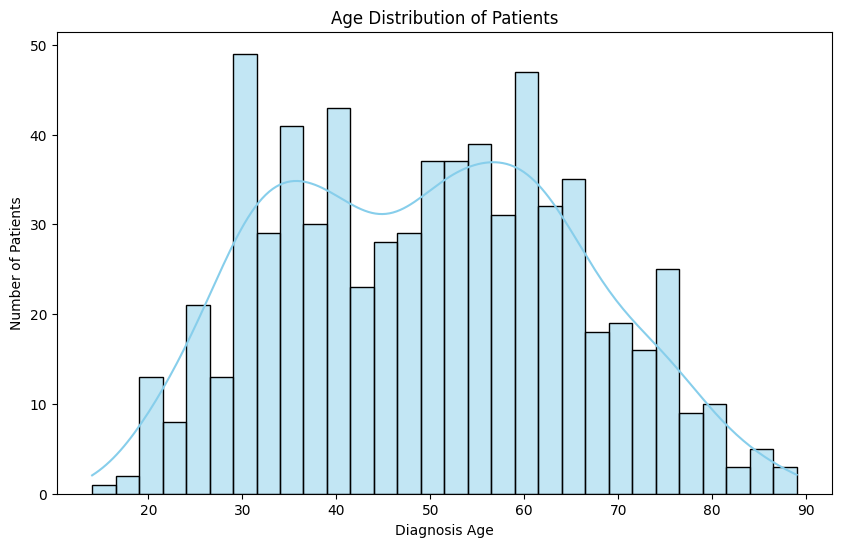

In [20]:
# Drop 'Sample ID' column and rows with NaNs in 'Pan-Glioma DNA Methylation Cluster'
cleaned_df = merged_before_norm_df.drop(columns=['Sample ID']).dropna(subset=['Pan-Glioma DNA Methylation Cluster'])

# Group by 'Patient ID' to get unique patient entries and setting Patient ID as index (use reset_index() to reverse when needed)
unique_patients_df = cleaned_df.groupby('Patient ID').first()

# Total unique patient count
total_unique_patients = unique_patients_df.shape[0]
print(f"Total Unique Patient Count: {total_unique_patients}")

# Sex distribution
sex_distribution = unique_patients_df['Sex'].value_counts()
print("\nSex Distribution:")
print(sex_distribution)

# Age distribution
print("\nAge Distribution Statistics:")
print(unique_patients_df['Diagnosis Age'].describe())

# Neoplasm Histologic Type distribution
neoplasm_type_distribution = unique_patients_df['Neoplasm Histologic Type Name'].value_counts()
print("\nNeoplasm Histologic Type Distribution:")
print(neoplasm_type_distribution)

# Neoplasm Histologic Grade distribution
neoplasm_grade_distribution = unique_patients_df['Neoplasm Histologic Grade'].value_counts()
print("\nNeoplasm Histologic Grade Distribution:")
print(neoplasm_grade_distribution)

# Plot the age distribution
plt.figure(figsize=(10, 6))
sns.histplot(unique_patients_df['Diagnosis Age'], kde=True, bins=30, color='skyblue')
plt.title('Age Distribution of Patients')
plt.xlabel('Diagnosis Age')
plt.ylabel('Number of Patients')
plt.show()

One-hot encoding of categorical values

In [21]:
# One-hot encode the Neoplasm Histologic Grade column with 0/1 encoding
encoded_grades_df = pd.get_dummies(unique_patients_df['Neoplasm Histologic Grade'], prefix='Grade').astype(int)

# Concatenate the encoded grades back to the main DataFrame
unique_patients_df = pd.concat([unique_patients_df, encoded_grades_df], axis=1)

# Drop the original Neoplasm Histologic Grade column as it is no longer needed
unique_patients_df = unique_patients_df.drop(columns=['Neoplasm Histologic Grade'])

# Encode Sex: 1 for 'Male', 0 for 'Female'
unique_patients_df['Sex'] = unique_patients_df['Sex'].map({'Male': 1, 'Female': 0}).astype(int)

# One-hot encode the Pan-Glioma DNA Methylation Cluster with 0/1 encoding
encoded_grades_df = pd.get_dummies(unique_patients_df['Pan-Glioma DNA Methylation Cluster'], prefix='Meth').astype(int)

# Concatenate the encoded grades back to the main DataFrame
unique_patients_df = pd.concat([unique_patients_df, encoded_grades_df], axis=1)

# Drop the original Neoplasm Histologic Grade column as it is no longer needed
unique_patients_df = unique_patients_df.drop(columns=['Pan-Glioma DNA Methylation Cluster'])

# Display the counts for each unique variable in the 'Neoplasm Histologic Type Name' column
type_counts = unique_patients_df['Neoplasm Histologic Type Name'].value_counts()

# Print the counts
print("Counts for each Neoplasm Histologic Type:")
print(type_counts)

# Ensure one-hot encoding columns are integers (1/0)
unique_patients_df = pd.concat([unique_patients_df, pd.get_dummies(unique_patients_df['Neoplasm Histologic Type Name'], prefix='Type').astype(int)], axis=1)

# Display the first few rows to verify
print("DataFrame with one-hot encoding:")
print(unique_patients_df.head())



Counts for each Neoplasm Histologic Type:
Neoplasm Histologic Type Name
glioblastoma         246
oligodendroglioma    170
astrocytoma          167
oligoastrocytoma     113
Name: count, dtype: int64
DataFrame with one-hot encoding:
              IDH1  TP53  ATRX  PTEN  TTN  EGFR  CIC  MUC16  PIK3CA  NF1  ...  \
Patient ID                                                                ...   
TCGA-02-0003     0     0     0     0    0     1    0      0       0    0  ...   
TCGA-02-0033     0     0     0     0    0     0    0      0       0    1  ...   
TCGA-02-0047     0     0     0     0    0     0    0      0       1    0  ...   
TCGA-02-0055     0     0     0     1    0     0    0      0       0    0  ...   
TCGA-02-2470     0     0     0     1    0     0    0      0       0    0  ...   

              Meth_LGm1  Meth_LGm2  Meth_LGm3  Meth_LGm4  Meth_LGm5  \
Patient ID                                                            
TCGA-02-0003          0          0          0          0   

Normalisation of numerical values

In [22]:
# Drop 'Neoplasm Histologic Type Name'
unique_patients_df = unique_patients_df.drop(columns=['Neoplasm Histologic Type Name'])

# Initialize the scaler
scaler = MinMaxScaler()

# Save the result into a new DataFrame
normalized_df = unique_patients_df.copy()

# Normalize 'Diagnosis Age' and 'TMB (nonsynonymous)' columns
normalized_df[['Diagnosis Age', 'TMB (nonsynonymous)']] = scaler.fit_transform(
    normalized_df[['Diagnosis Age', 'TMB (nonsynonymous)']]
)

# Display the resulting DataFrame for verification
print("Normalized DataFrame with Diagnosis Age and TMB (nonsynonymous):")
print(normalized_df.head())

Normalized DataFrame with Diagnosis Age and TMB (nonsynonymous):
              IDH1  TP53  ATRX  PTEN  TTN  EGFR  CIC  MUC16  PIK3CA  NF1  ...  \
Patient ID                                                                ...   
TCGA-02-0003     0     0     0     0    0     1    0      0       0    0  ...   
TCGA-02-0033     0     0     0     0    0     0    0      0       0    1  ...   
TCGA-02-0047     0     0     0     0    0     0    0      0       1    0  ...   
TCGA-02-0055     0     0     0     1    0     0    0      0       0    0  ...   
TCGA-02-2470     0     0     0     1    0     0    0      0       0    0  ...   

              Meth_LGm1  Meth_LGm2  Meth_LGm3  Meth_LGm4  Meth_LGm5  \
Patient ID                                                            
TCGA-02-0003          0          0          0          0          1   
TCGA-02-0033          0          0          0          0          1   
TCGA-02-0047          0          0          0          0          0   
TCGA-02-0055

##  Clustering of Molecular Subtypes

Goal: Discover molecular subtypes of the cancer based on mutation patterns and clinical features with unsupervised machine learnong.

Features to Use: Hugo_Symbol, Grade, Type, Methylation, Sex, Age and TMB.

Approach: Use algorithms like K-Means, Hierarchical Clustering, or DBSCAN for clustering. Apply dimensionality reduction techniques like PCA or UMAP to visualize the clusters.

Evaluation: Examine how clusters correlate with clinical features such as survival outcomes, IDH status, or WHO Grade

In [23]:
clustering_df= normalized_df.copy()


### PCA and hierarchical clustering

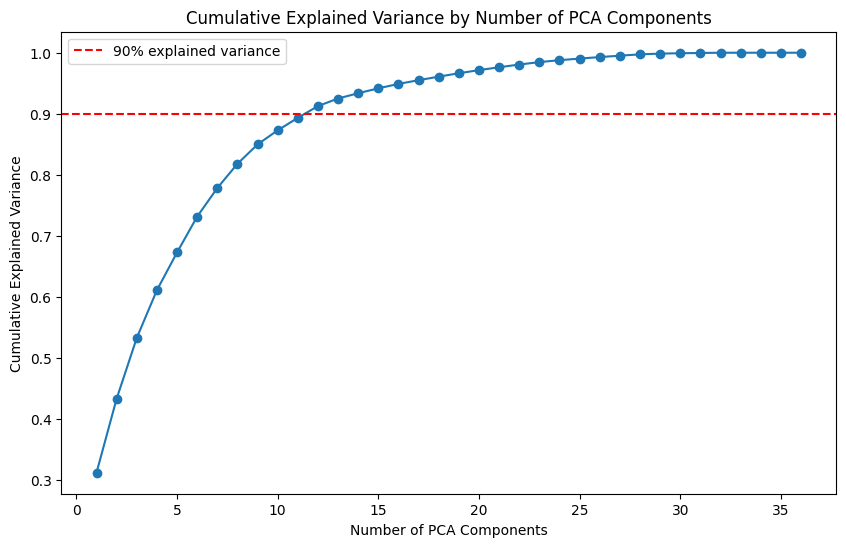

In [24]:
# Step 1: Define the features for PCA, excluding 'Patient ID' since it's now the index
features = clustering_df  # Index already set; no need to drop 'Patient ID'

# Step 2: Apply PCA without specifying n_components initially to calculate explained variance
pca = PCA()
pca.fit(features)

# Step 3: Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Step 4: Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of PCA Components')
plt.axhline(y=0.9, color='r', linestyle='--', label="90% explained variance")
plt.legend()
plt.show()

Total Variance Explained by 12 Components: 0.9125


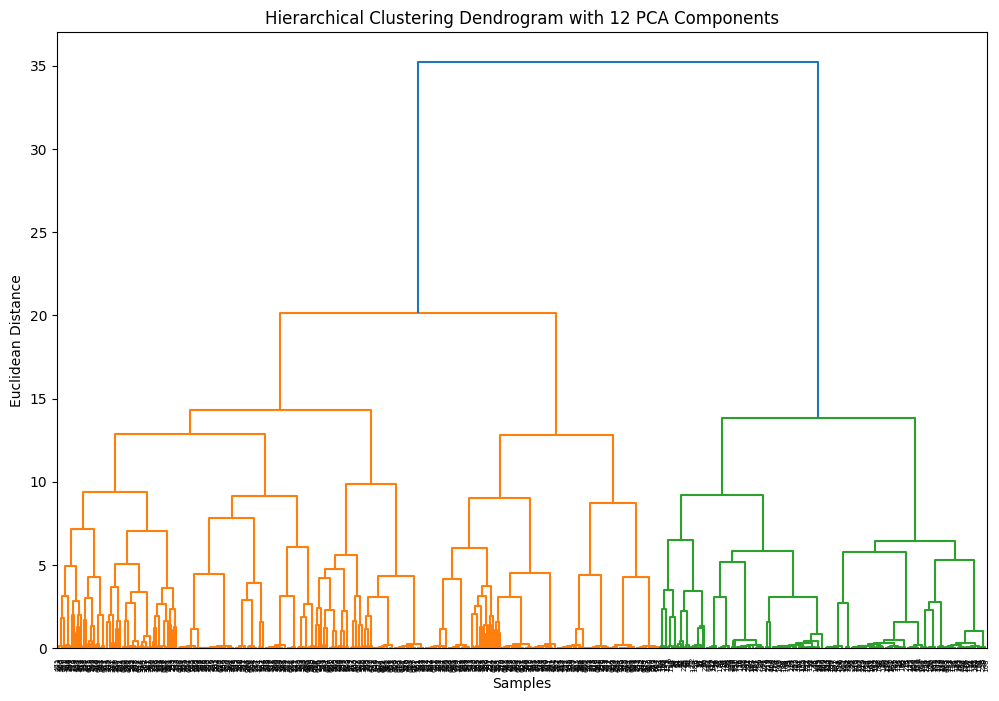

In [26]:
# Step 1: Perform PCA on clustering_df and reduce to 12 components
pca = PCA(n_components=12)
pca_result = pca.fit_transform(clustering_df)

# Print the explained variance ratio for PCA
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Total Variance Explained by 12 Components: {explained_variance:.4f}")

# Step 2: Perform hierarchical clustering on PCA-reduced data
linked = linkage(pca_result, method='ward')

# Step 3: Plot the dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=False)
plt.title("Hierarchical Clustering Dendrogram with 12 PCA Components")
plt.xlabel("Samples")
plt.ylabel("Euclidean Distance")
plt.show()




Cut off of 12 seems to give 7 well defined clusters.


Cluster Counts:
Cluster
2    124
1    122
6    103
4     99
7     90
5     82
3     76
Name: count, dtype: int64

Original DataFrame with Cluster Assignments:
     Patient ID        Sample ID  IDH1  TP53  ATRX  PTEN  TTN  EGFR  CIC  \
0  TCGA-02-0003  TCGA-02-0003-01     0     0     0     0    0     1    0   
1  TCGA-02-0003  TCGA-02-0003-01     0     0     0     0    0     0    0   
2  TCGA-02-0003  TCGA-02-0003-01     0     1     0     0    0     0    0   
3  TCGA-02-0003  TCGA-02-0003-01     0     1     0     0    0     0    0   
4  TCGA-02-0033  TCGA-02-0033-01     0     0     0     0    0     0    0   

   MUC16  ...  PKHD1  LRP2  RB1  Diagnosis Age   Sex  TMB (nonsynonymous)  \
0      0  ...      0     0    0             50  Male             1.366667   
1      0  ...      0     0    0             50  Male             1.366667   
2      0  ...      0     0    0             50  Male             1.366667   
3      0  ...      0     0    0             50  Male             1.366667  

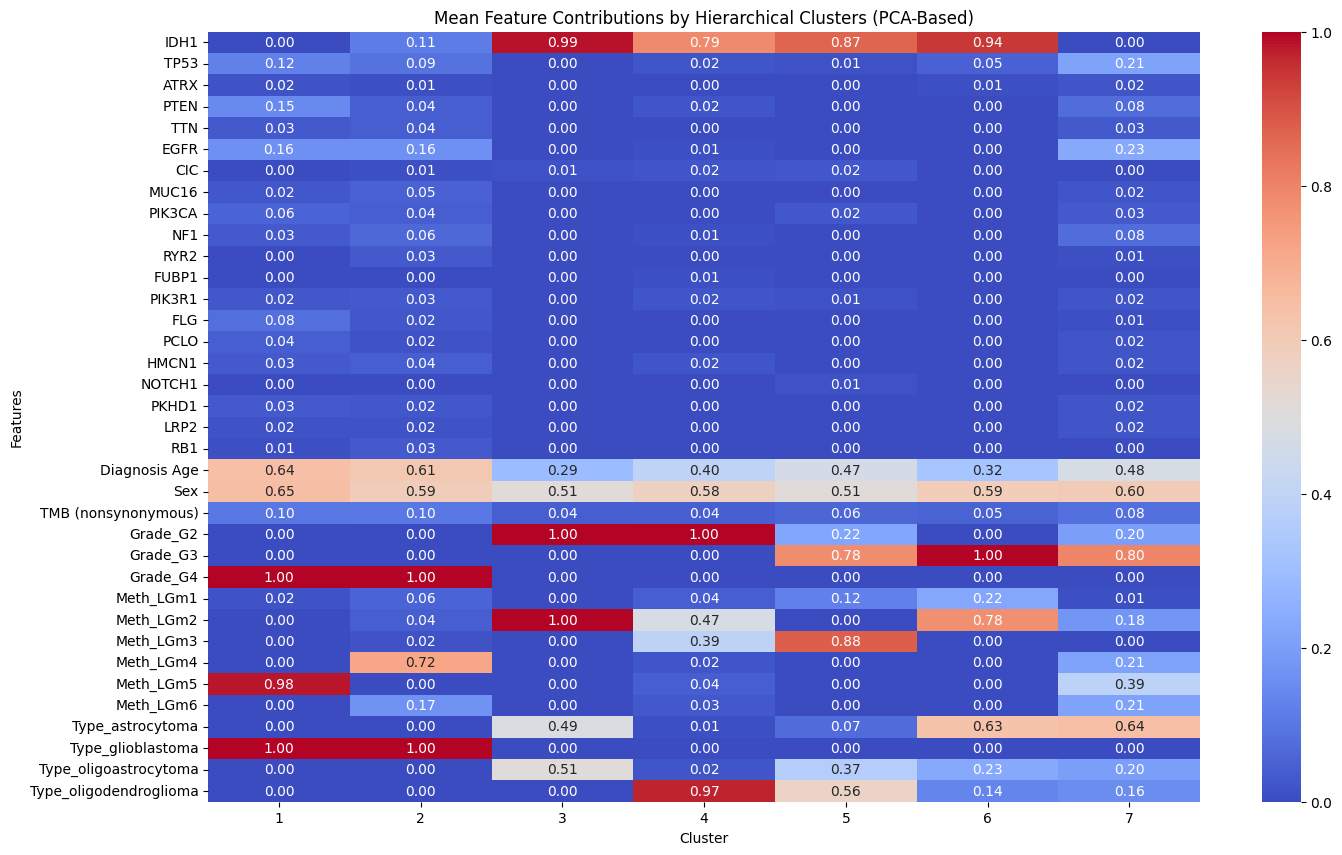

In [27]:
# Step 4: Define clusters based on a distance cutoff
distance_cutoff = 12  # Adjust based on dendrogram inspection
clusters = fcluster(linked, distance_cutoff, criterion='distance')

# Add cluster labels to clustering_df
clustering_df = clustering_df.copy()  # Ensure original DataFrame is not modified
clustering_df['Cluster'] = clusters

# Step 5: Reset index and add 'Patient ID' back if necessary
post_clustering_df = clustering_df.reset_index()

# Verify cluster counts
print("\nCluster Counts:")
print(post_clustering_df['Cluster'].value_counts())

# Step 6: Merge cluster labels back into the original untransformed data
merged_before_norm_df_with_clusters = merged_before_norm_df.merge(
    post_clustering_df[['Patient ID', 'Cluster']], on='Patient ID', how='left'
)

# Verify the merged DataFrame
print("\nOriginal DataFrame with Cluster Assignments:")
print(merged_before_norm_df_with_clusters.head())

# Step 7: Define numeric and non-numeric columns
numeric_columns = post_clustering_df.select_dtypes(include=[np.number]).columns
non_numeric_columns = post_clustering_df.select_dtypes(exclude=[np.number]).columns

# Step 8: Group by cluster and calculate summary statistics
cluster_profile = post_clustering_df.groupby('Cluster').agg({
    **{col: ['mean', 'median'] for col in numeric_columns if col not in ['Cluster']},
    **{col: lambda x: x.value_counts().idxmax() for col in non_numeric_columns if col not in ['Cluster', 'Patient ID']}
})

# Display cluster profiles
print("\nCluster Profile Summary:")
print(cluster_profile)

# Step 9: Renumber clusters to ensure sequential numbering
unique_clusters = pd.Series(clusters).unique()
renumber_map = {old: new for new, old in enumerate(sorted(unique_clusters), start=1)}
clustering_df['Cluster'] = clustering_df['Cluster'].map(renumber_map)

# Step 10: Calculate mean feature values for each cluster
cluster_features_hierarchical = clustering_df.groupby('Cluster').mean()

# Step 11: Plot heatmap of mean feature values by cluster
plt.figure(figsize=(16, 10))
sns.heatmap(cluster_features_hierarchical.T, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Mean Feature Contributions by Hierarchical Clusters (PCA-Based)')
plt.xlabel('Cluster')
plt.ylabel('Features')
plt.show()

In [28]:
# Step 1: Transpose cluster_features to match heatmap layout (clusters as columns)
cluster_features_hierarchical_T = cluster_features_hierarchical.T

# Step 2: Identify top features for each cluster
top_features_per_cluster = {}

for cluster in cluster_features_hierarchical_T.columns:  # Clusters are now columns
    # Sort features by their contribution for the current cluster
    top_features = cluster_features_hierarchical_T[cluster].sort_values(ascending=False)
    top_features_per_cluster[cluster] = top_features.head(5)  # Top 5 features, adjust as needed

# Step 3: Print the top features for each cluster
for cluster, features in top_features_per_cluster.items():
    print(f"\nTop Features for Cluster {cluster}:")
    print(features)


Top Features for Cluster 1:
Grade_G4             1.000000
Type_glioblastoma    1.000000
Meth_LGm5            0.983607
Sex                  0.647541
Diagnosis Age        0.642732
Name: 1, dtype: float64

Top Features for Cluster 2:
Type_glioblastoma    1.000000
Grade_G4             1.000000
Meth_LGm4            0.717742
Diagnosis Age        0.612366
Sex                  0.588710
Name: 2, dtype: float64

Top Features for Cluster 3:
Meth_LGm2                1.000000
Grade_G2                 1.000000
IDH1                     0.986842
Type_oligoastrocytoma    0.513158
Sex                      0.513158
Name: 3, dtype: float64

Top Features for Cluster 4:
Grade_G2                  1.000000
Type_oligodendroglioma    0.969697
IDH1                      0.787879
Sex                       0.575758
Meth_LGm2                 0.474747
Name: 4, dtype: float64

Top Features for Cluster 5:
Meth_LGm3                 0.878049
IDH1                      0.865854
Grade_G3                  0.780488
Type_olig

The only genetic feature that contributes to clustering seems to be IDH1 status, additional molecular feature that is important - methylation pattern.

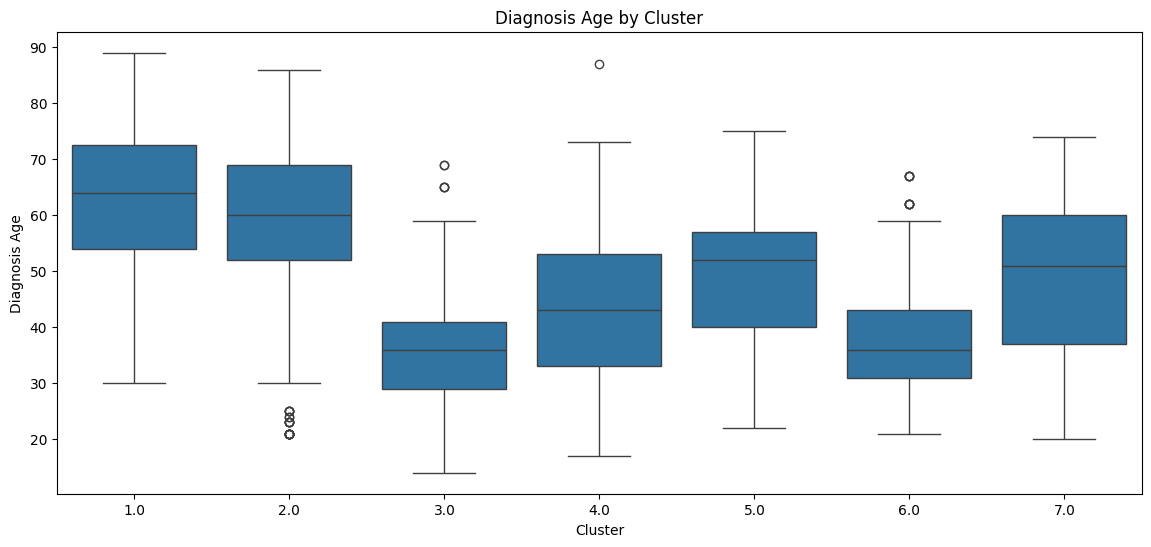

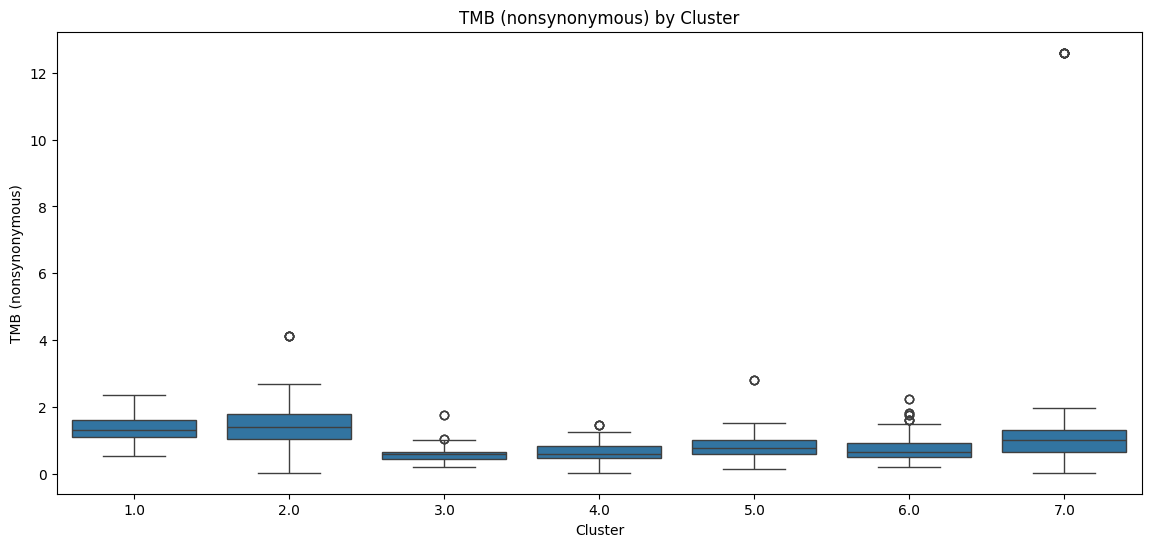

In [34]:

# Box plot for Diagnosis Age and TMB (nonsynonymous)
plt.figure(figsize=(14, 6))
sns.boxplot(data=merged_before_norm_df_with_clusters, x='Cluster', y='Diagnosis Age')
plt.title('Diagnosis Age by Cluster')
plt.show()

plt.figure(figsize=(14, 6))
sns.boxplot(data=merged_before_norm_df_with_clusters, x='Cluster', y='TMB (nonsynonymous)')
plt.title('TMB (nonsynonymous) by Cluster')
plt.show()


### Non-hierarchical clustering after UMAP

 UMAP helps reduce noise in the data by compressing irrelevant information. Reducing dimensions with UMAP allows clustering algorithms to work more efficiently and effectively, often yielding more distinct and accurate clusters by focusing on the most important features.

/Users/glusker/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


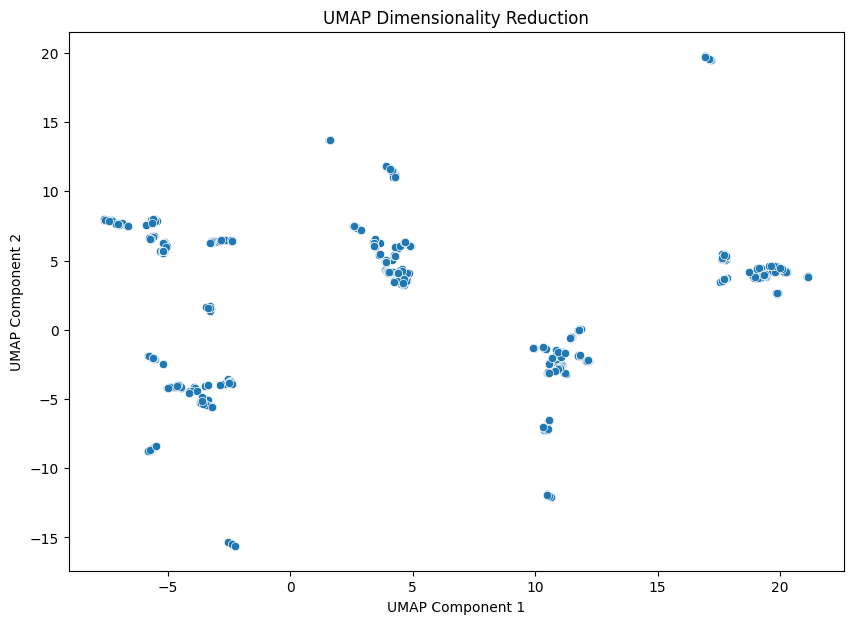

In [35]:
# 1. UMAP dimensionality reduction
reducer = umap.UMAP(n_neighbors=20, min_dist=0.1, metric='euclidean', random_state=42)
umap_data = reducer.fit_transform(clustering_df)

# Plot UMAP result
plt.figure(figsize=(10, 7))
sns.scatterplot(x=umap_data[:, 0], y=umap_data[:, 1])
plt.title('UMAP Dimensionality Reduction')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()






After UMAP dimentionality reduction we want to perform non-hierarchical clustering. Our choice is between DBSCAN, K-Means and GMM. Our metrics are Silhouette Score (value ranges from -1 to +1) and Davies-Bouldin Index (from 0).

DBI < 1: Indicates very good clustering. DBI around 1–1.5: Suggests acceptable clustering quality. DBI > 2: Indicates poor clustering (clusters overlap significantly or are not compact).

SS close to +1 is generally considered excellent, indicating well-separated, distinct clusters. Values between 0.5 and 1 indicate good clustering, but there may still be some overlap. Values close to 0 suggest poor clustering, with significant overlap between clusters. Negative values suggest incorrect clustering, where points are closer to other clusters than to their own.

In [36]:
# DBSCAN Clustering
dbscan = DBSCAN(eps=0.2, min_samples=5).fit(umap_data)
dbscan_labels = dbscan.labels_ + 1  # Increment labels to start from 1
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan.labels_ else 0)

# Calculate DBSCAN metrics (if there are >1 clusters)
if n_clusters_dbscan > 1:
    dbscan_silhouette = silhouette_score(umap_data, dbscan_labels)
    dbscan_davies_bouldin = davies_bouldin_score(umap_data, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_davies_bouldin = None

# Print DBSCAN results
print(f"DBSCAN - Number of Clusters: {n_clusters_dbscan}")
print(f"DBSCAN - Silhouette Score: {dbscan_silhouette}, Davies-Bouldin Index: {dbscan_davies_bouldin}")


DBSCAN - Number of Clusters: 49
DBSCAN - Silhouette Score: 0.6836624145507812, Davies-Bouldin Index: 1.0275298854160868


47 is too many clusters for 695 patients, it does not seem to give us valuable information.

In [37]:
# Test Clusters (6–16) for K-Means and GMM
cluster_range = range(6, 17)  # 6 to 16 clusters
results = []

for n_clusters in cluster_range:
    print(f"\nTesting {n_clusters} clusters:")

    # K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(umap_data)
    kmeans_labels = kmeans.labels_ + 1  # Increment labels to start from 1
    kmeans_silhouette = silhouette_score(umap_data, kmeans_labels)
    kmeans_davies_bouldin = davies_bouldin_score(umap_data, kmeans_labels)
    print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_davies_bouldin:.4f}")

    # GMM
    gmm = GaussianMixture(n_components=n_clusters, random_state=42).fit(umap_data)
    gmm_labels = gmm.predict(umap_data) + 1  # Increment labels to start from 1
    gmm_silhouette = silhouette_score(umap_data, gmm_labels)
    gmm_davies_bouldin = davies_bouldin_score(umap_data, gmm_labels)
    print(f"GMM - Silhouette Score: {gmm_silhouette:.4f}, Davies-Bouldin Index: {gmm_davies_bouldin:.4f}")

    # Store results
    results.append({
        "Clusters": n_clusters,
        "K-Means Silhouette": kmeans_silhouette,
        "K-Means Davies-Bouldin": kmeans_davies_bouldin,
        "GMM Silhouette": gmm_silhouette,
        "GMM Davies-Bouldin": gmm_davies_bouldin,
    })

# Create Results DataFrame
results_df = pd.DataFrame(results)

# Automatically Select Best Number of Clusters
# Based on Silhouette Score
best_kmeans_silhouette = results_df.loc[results_df["K-Means Silhouette"].idxmax(), "Clusters"]
best_gmm_silhouette = results_df.loc[results_df["GMM Silhouette"].idxmax(), "Clusters"]

# Based on Davies-Bouldin Index (lower is better)
best_kmeans_davies_bouldin = results_df.loc[results_df["K-Means Davies-Bouldin"].idxmin(), "Clusters"]
best_gmm_davies_bouldin = results_df.loc[results_df["GMM Davies-Bouldin"].idxmin(), "Clusters"]

# Print the best cluster numbers
print(f"\nBest K-Means Clusters by Silhouette Score: {best_kmeans_silhouette} clusters")
print(f"Best GMM Clusters by Silhouette Score: {best_gmm_silhouette} clusters")
print(f"Best K-Means Clusters by Davies-Bouldin Index: {best_kmeans_davies_bouldin} clusters")
print(f"Best GMM Clusters by Davies-Bouldin Index: {best_gmm_davies_bouldin} clusters")


Testing 6 clusters:
K-Means - Silhouette Score: 0.6635, Davies-Bouldin Index: 0.5507
GMM - Silhouette Score: 0.6635, Davies-Bouldin Index: 0.5507

Testing 7 clusters:
K-Means - Silhouette Score: 0.7030, Davies-Bouldin Index: 0.4590
GMM - Silhouette Score: 0.7030, Davies-Bouldin Index: 0.4590

Testing 8 clusters:
K-Means - Silhouette Score: 0.6819, Davies-Bouldin Index: 0.3368
GMM - Silhouette Score: 0.6819, Davies-Bouldin Index: 0.3368

Testing 9 clusters:
K-Means - Silhouette Score: 0.6229, Davies-Bouldin Index: 0.4243
GMM - Silhouette Score: 0.6229, Davies-Bouldin Index: 0.4243

Testing 10 clusters:
K-Means - Silhouette Score: 0.6466, Davies-Bouldin Index: 0.4308
GMM - Silhouette Score: 0.6466, Davies-Bouldin Index: 0.4308

Testing 11 clusters:
K-Means - Silhouette Score: 0.6769, Davies-Bouldin Index: 0.3954
GMM - Silhouette Score: 0.6769, Davies-Bouldin Index: 0.3954

Testing 12 clusters:
K-Means - Silhouette Score: 0.6657, Davies-Bouldin Index: 0.4183
GMM - Silhouette Score: 0.665

DBI and SS values for GMM and K-Means are the same, indicating that it does not matter which model to use. We continue with K-Means.

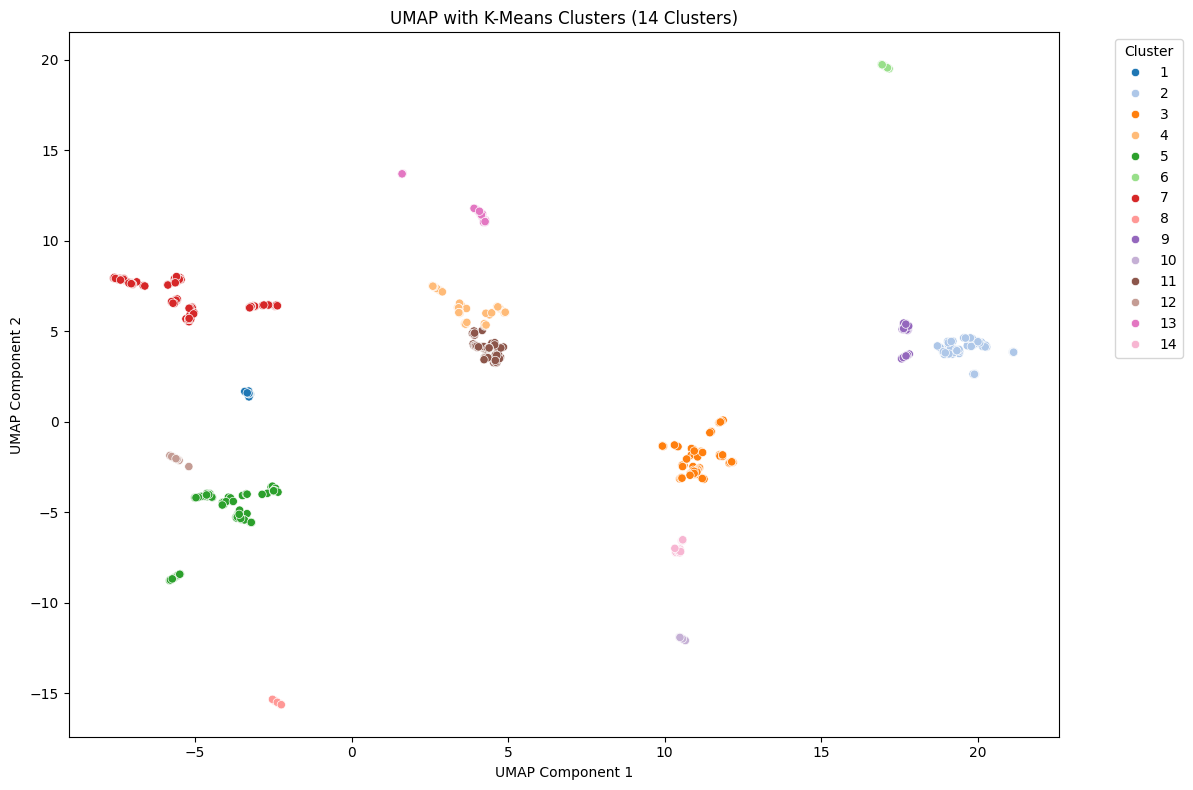

In [38]:
# Define the number of clusters
n_clusters = 14

# K-Means Clustering for 14 Clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(umap_data)
kmeans_labels = kmeans.labels_ + 1  # Increment labels to start from 1

# Plot UMAP with K-Means Clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=umap_data[:, 0],
    y=umap_data[:, 1],
    hue=kmeans_labels,
    palette=sns.color_palette("tab20", n_clusters),  # Use tab20 for distinct colors
    legend="full"
)
plt.title(f"UMAP with K-Means Clusters ({n_clusters} Clusters)")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.legend(
    title="Cluster",
    bbox_to_anchor=(1.05, 1),  # Place legend to the right of the plot
    loc="upper left"
)
plt.tight_layout()
plt.show()


14 clusters give very good separation. Now we want to explore what features contribute most to the clusters.

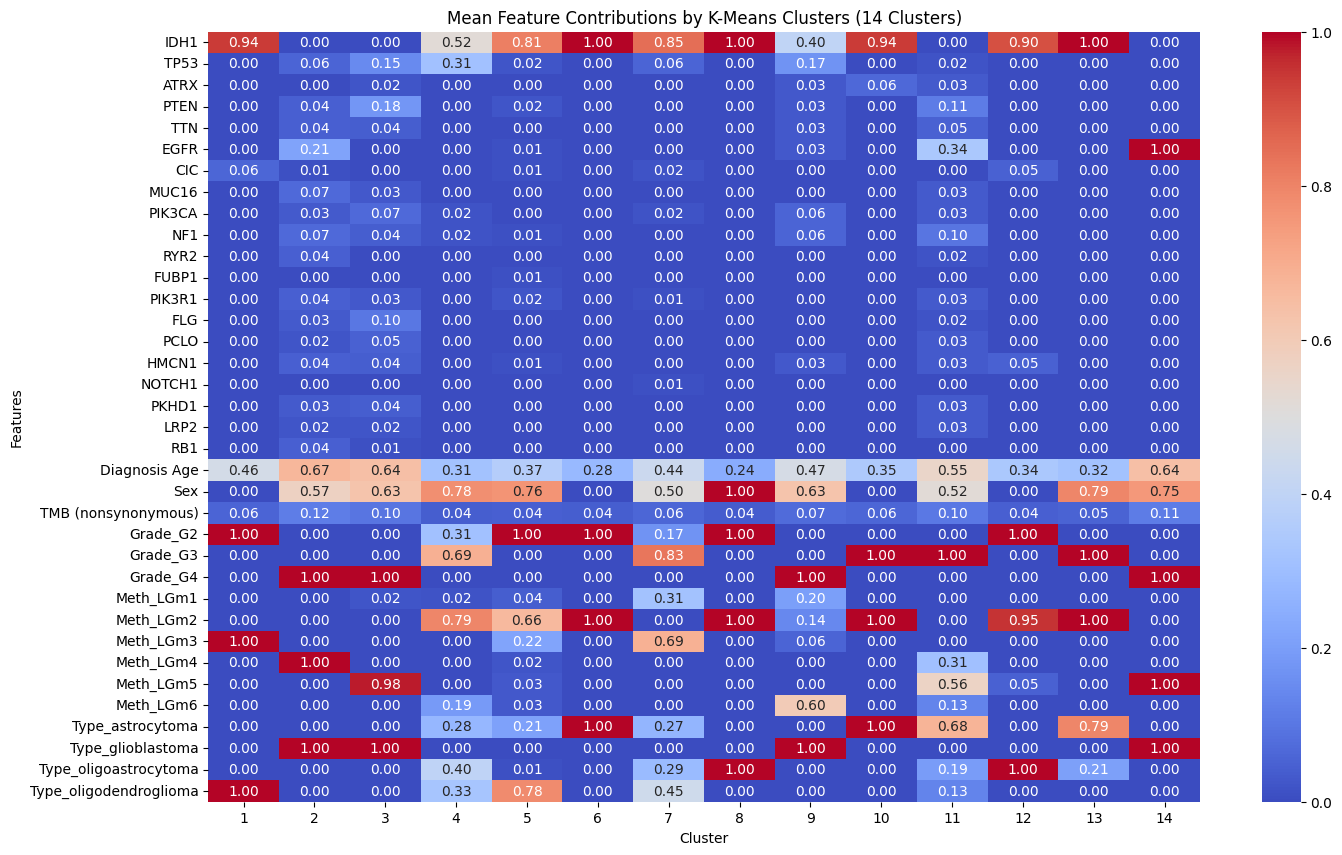

In [39]:
# Step 1: Add cluster labels to the original DataFrame
clustering_df['Cluster'] = kmeans_labels  # Ensure labels are from K-Means

# Step 2: Calculate mean feature values for each cluster
cluster_features = clustering_df.groupby('Cluster').mean()

# Step 3: Plot heatmap of feature contributions
plt.figure(figsize=(16, 10))
sns.heatmap(cluster_features.T, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Mean Feature Contributions by K-Means Clusters (14 Clusters)')
plt.xlabel('Cluster')
plt.ylabel('Features')
plt.show()


In [40]:
# Step 1: Count the number of patients in each cluster
patients_per_cluster = clustering_df['Cluster'].value_counts().sort_index()

# Step 2: Print the number of patients per cluster
print("Number of Patients Per Cluster:")
print(patients_per_cluster)


Number of Patients Per Cluster:
Cluster
1      17
2      89
3     102
4      58
5     101
6      17
7     105
8      19
9      35
10     16
11     62
12     21
13     34
14     20
Name: count, dtype: int64


In [41]:
# Step 1: Transpose cluster_features to match heatmap layout (clusters as columns)
cluster_features_T = cluster_features.T

# Step 2: Identify top features for each cluster
top_features_per_cluster = {}

for cluster in cluster_features_T.columns:  # Clusters are now columns
    # Sort features by their contribution for the current cluster
    top_features = cluster_features_T[cluster].sort_values(ascending=False)
    top_features_per_cluster[cluster] = top_features.head(5)  # Top 5 features, adjust as needed

# Step 3: Print the top features for each cluster
for cluster, features in top_features_per_cluster.items():
    print(f"\nTop Features for Cluster {cluster}:")
    print(features)



Top Features for Cluster 1:
Type_oligodendroglioma    1.000000
Grade_G2                  1.000000
Meth_LGm3                 1.000000
IDH1                      0.941176
Diagnosis Age             0.462745
Name: 1, dtype: float64

Top Features for Cluster 2:
Meth_LGm4            1.000000
Type_glioblastoma    1.000000
Grade_G4             1.000000
Diagnosis Age        0.668315
Sex                  0.573034
Name: 2, dtype: float64

Top Features for Cluster 3:
Grade_G4             1.000000
Type_glioblastoma    1.000000
Meth_LGm5            0.980392
Diagnosis Age        0.642745
Sex                  0.627451
Name: 3, dtype: float64

Top Features for Cluster 4:
Meth_LGm2                0.793103
Sex                      0.775862
Grade_G3                 0.689655
IDH1                     0.517241
Type_oligoastrocytoma    0.396552
Name: 4, dtype: float64

Top Features for Cluster 5:
Grade_G2                  1.000000
IDH1                      0.811881
Type_oligodendroglioma    0.782178
Sex      

Here we can see more additional feature contributing to clustering: EGFR. Main contributions are still from methylation profile, IDH1 status and diagnosis.

## Prediction


Goal: Use supervised machine learning to predict patient diagnosis and survival outcomes based on molecular and clinical features.

Features: Hugo_Symbol, Grade, Type, Methylation, Sex, Age, TMB

Approach: 

        Classification: Use algorithms like Random Forest or SVM for diagnosis.
    
        Regression: Use XGBoost or Linear Regression for survival prediction.
    
        Preprocessing: Normalize/standardize features like Age and TMB.

Evaluation: Cross-validation for model robustness. Use accuracy, precision, recall, F1-score, and ROC-AUC score.

For this we need to do some additional data processing.

In [42]:
#Resetting index to bring column Patient ID back
clustering_df=clustering_df.reset_index()

# Create the 'prediction' DataFrame based on clustering_df by dropping the 'Cluster' column
prediction = clustering_df.drop(columns=['Cluster']).copy()

# Filter clinical_data to include only the 688 Patient IDs present in clustering_df
filtered_clinical_data = clinical_data[clinical_data['Patient ID'].isin(prediction['Patient ID'])]

# Merge 'Overall Survival Status' directly from clinical_data into prediction based on 'Patient ID'
prediction = prediction.merge(
    filtered_clinical_data[['Patient ID', 'Overall Survival (Months)','Overall Survival Status']],
    on='Patient ID',
    how='left'
)

# Confirm the merge by checking unique values and any missing entries in 'Overall Survival Status'
print("Unique values in 'Overall Survival Status' in prediction:", prediction['Overall Survival Status'].unique())
print("Number of missing values in 'Overall Survival Status':", prediction['Overall Survival Status'].isna().sum())

# Display the final DataFrame to confirm the structure
prediction

Unique values in 'Overall Survival Status' in prediction: ['1:DECEASED' '0:LIVING' nan]
Number of missing values in 'Overall Survival Status': 1


,Patient ID,IDH1,TP53,ATRX,PTEN,TTN,EGFR,CIC,MUC16,PIK3CA,...,Meth_LGm3,Meth_LGm4,Meth_LGm5,Meth_LGm6,Type_astrocytoma,Type_glioblastoma,Type_oligoastrocytoma,Type_oligodendroglioma,Overall Survival (Months),Overall Survival Status
0,TCGA-02-0003,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,4.7,1:DECEASED
1,TCGA-02-0033,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,2.8,1:DECEASED
2,TCGA-02-0047,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,1,0,0,14.7,1:DECEASED
3,TCGA-02-0055,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,2.5,1:DECEASED
4,TCGA-02-2470,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,12.9,1:DECEASED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,TCGA-VW-A7QS,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,23.2,0:LIVING
692,TCGA-VW-A8FI,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,8.0,1:DECEASED
693,TCGA-W9-A837,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,45.0,0:LIVING
694,TCGA-WH-A86K,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,5.3,0:LIVING


In [43]:
# Map 'Overall Survival Status' to 0 for 'LIVING' and 1 for 'DECEASED'
prediction['Overall Survival Status'] = prediction['Overall Survival Status'].map({'0:LIVING': 0, '1:DECEASED': 1})

# Verify the transformation and check for any remaining NaN values
print("Unique values in 'Overall Survival Status' after transformation:", prediction['Overall Survival Status'].unique())
print("Number of missing values in 'Overall Survival Status' after transformation:", prediction['Overall Survival Status'].isna().sum())

#Drop columns with NaN
prediction = prediction.dropna()

# Convert 'Overall Survival Status' to integer type to remove decimals
prediction['Overall Survival Status'] = prediction['Overall Survival Status'].astype('Int64')

# Display the final DataFrame to confirm the transformation
prediction

Unique values in 'Overall Survival Status' after transformation: [ 1.  0. nan]
Number of missing values in 'Overall Survival Status' after transformation: 1


/var/folders/tn/yx1ylmyx7n9ccd0yfynwzmr80000gq/T/ipykernel_27378/476421946.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Overall Survival Status'] = prediction['Overall Survival Status'].astype('Int64')


,Patient ID,IDH1,TP53,ATRX,PTEN,TTN,EGFR,CIC,MUC16,PIK3CA,...,Meth_LGm3,Meth_LGm4,Meth_LGm5,Meth_LGm6,Type_astrocytoma,Type_glioblastoma,Type_oligoastrocytoma,Type_oligodendroglioma,Overall Survival (Months),Overall Survival Status
0,TCGA-02-0003,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,4.7,1
1,TCGA-02-0033,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,2.8,1
2,TCGA-02-0047,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,1,0,0,14.7,1
3,TCGA-02-0055,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,2.5,1
4,TCGA-02-2470,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,12.9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,TCGA-VW-A7QS,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,23.2,0
692,TCGA-VW-A8FI,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,8.0,1
693,TCGA-W9-A837,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,45.0,0
694,TCGA-WH-A86K,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,5.3,0


In [44]:
# Save the cleaned DataFrame
prediction.to_csv('prediction20.csv', index=False)

**Molecular diagnostics using machine learning**

We are using methods descirbed and published in Tasci et al., Int. J. Mol. Sci. 2022 (doi: 10.3390/ijms232214155). 

Authors propose a novel hierarchical voting-based methodology for improving the performance results of the feature selection stage and machine learning models for glioma grading with clinical and molecular predictors.

The goal is to distinguish Glioblastoma (HGG, Grade 4) from Low Grade Glioma (LGG, Grade 2 or Grade 3).

In [45]:
# Drop the specified columns
diagnosis = prediction.drop(columns=['Overall Survival (Months)', 'Overall Survival Status',
                                     'Type_astrocytoma', 'Type_glioblastoma',
                                     'Type_oligoastrocytoma', 'Type_oligodendroglioma'])

# Merge 'Grade_G2', 'Grade_G3', and 'Grade_G4' into one column 'Glioblastoma'
# Encode 'Glioblastoma' as 1 for 'Grade_G4' and 0 for 'Grade_G2' and 'Grade_G3'
diagnosis['Glioblastoma'] = diagnosis[['Grade_G2', 'Grade_G3', 'Grade_G4']].apply(
    lambda x: 1 if x['Grade_G4'] == 1 else 0, axis=1
)

# Drop original grade columns after merging
diagnosis = diagnosis.drop(columns=['Grade_G2', 'Grade_G3', 'Grade_G4'])

# Display the transformed DataFrame
diagnosis.head()

,Patient ID,IDH1,TP53,ATRX,PTEN,TTN,EGFR,CIC,MUC16,PIK3CA,...,Diagnosis Age,Sex,TMB (nonsynonymous),Meth_LGm1,Meth_LGm2,Meth_LGm3,Meth_LGm4,Meth_LGm5,Meth_LGm6,Glioblastoma
0,TCGA-02-0003,0,0,0,0,0,1,0,0,0,...,0.480000,1,0.106101,0,0,0,0,1,0,1
1,TCGA-02-0033,0,0,0,0,0,0,0,0,0,...,0.533333,1,0.053050,0,0,0,0,1,0,1
2,TCGA-02-0047,0,0,0,0,0,0,0,0,1,...,0.853333,1,0.119363,0,0,0,0,0,1,1
3,TCGA-02-0055,0,0,0,1,0,0,0,0,0,...,0.640000,0,0.108753,0,0,0,0,1,0,1
4,TCGA-02-2470,0,0,0,1,0,0,0,0,0,...,0.573333,1,0.111406,0,0,0,0,1,0,1


For feature selection we use hierarchical voting-based methodology for the feature selection stage: 4 methods are used (weight of evidence, recursive feature elimination, Random Forest, and least absolute shrinkage and selection operator (LASSO)), to rank features individually by employing the five supervised learning models according to their importance levels (e.g., if the importance level of the feature is equal to 0, it is disregarded). If the minimum number of votes is equal to 1, this means the feature to be selected must have at least a total of 1 vote from the four feature selection methods. The feature is preserved if chosen by at least three methods out of four. 

Importantly, our dataset is imbalanced (LGG 450, HGG 245) so we need to calculate sampe weight to be able to create precise enough model. 

In [46]:
# Define features (X) and target variable (y) while retaining Patient ID
X = diagnosis.drop(columns=['Glioblastoma'])
y = diagnosis['Glioblastoma']

# Step 1: Calculate Sample Weights
sample_weights = compute_sample_weight('balanced', y)

# Step 2: Apply each feature selection method

# 2a. Calculate Weight of Evidence (WoE) for each feature
def calculate_woe(feature, target):
    feature_data = pd.crosstab(feature, target, normalize='columns')
    woe = np.log((feature_data[1] + 1e-5) / (feature_data[0] + 1e-5))
    return abs(woe.sum())

woe_importance = [calculate_woe(X[feature], y) for feature in X.columns.drop('Patient ID')]
woe_threshold = 0.001  # Adjust as needed
woe_selected = [woe >= woe_threshold for woe in woe_importance]

# 2b. RFE with Logistic Regression using sample weights
rfe_lr = RFE(estimator=LogisticRegression(max_iter=1000, class_weight='balanced'))
rfe_lr.fit(X.drop(columns=['Patient ID']), y, sample_weight=sample_weights)

# 2c. Random Forest for feature importance using sample weights
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X.drop(columns=['Patient ID']), y, sample_weight=sample_weights)
rf_importances = rf.feature_importances_
rf_selected = rf_importances > 0.001  # Adjust threshold as needed

# 2d. LASSO for feature selection using sample weights
lasso = Lasso(alpha=0.001)  # Adjust alpha as needed
lasso.fit(X.drop(columns=['Patient ID']), y, sample_weight=sample_weights)
lasso_importances = lasso.coef_
lasso_selected = lasso_importances != 0

# Step 3: Combine selections with voting (at least three methods)
selected_features = pd.DataFrame({
    'Feature': X.columns.drop('Patient ID'),
    'WoE_Importance': woe_selected,
    'RFE_LR': rfe_lr.support_,
    'RF_Importance': rf_selected,
    'LASSO_Importance': lasso_selected
})

# Voting rule: Retain features selected by at least three methods
selected_features['Selected'] = (
    selected_features[['WoE_Importance', 'RFE_LR', 'RF_Importance', 'LASSO_Importance']].sum(axis=1) >= 3
)

# Final list of selected features, including Patient ID for tracking
final_selected_features = ['Patient ID'] + selected_features[selected_features['Selected']]['Feature'].tolist()

# Print the final list and count
print("Final selected features:", final_selected_features)
print(f"Number of selected features: {len(final_selected_features) - 1}")  # Exclude 'Patient ID'

Final selected features: ['Patient ID', 'TP53', 'EGFR', 'PIK3CA', 'NF1', 'PIK3R1', 'FLG', 'LRP2', 'Diagnosis Age', 'Sex', 'TMB (nonsynonymous)', 'Meth_LGm1', 'Meth_LGm2', 'Meth_LGm3', 'Meth_LGm4', 'Meth_LGm5', 'Meth_LGm6']
Number of selected features: 16


In [47]:
# Define the features (X) and target (y) using the `diagnosis` DataFrame
X = diagnosis[final_selected_features].drop(columns=['Patient ID'])
y = diagnosis['Glioblastoma']

# Step 1: Calculate Sample Weights
sample_weights = compute_sample_weight('balanced', y)

# Initialize models
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
svm = SVC(probability=True, class_weight='balanced', random_state=42)
knn = KNeighborsClassifier()
ada = AdaBoostClassifier(algorithm='SAMME', random_state=42)

# Combine models using a voting ensemble
voting_clf = VotingClassifier(estimators=[
    ('logreg', logreg),
    ('rf', rf),
    ('svm', svm),
    ('knn', knn),
    ('ada', ada)
], voting='soft')

# Cross-validation setup
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Evaluate each model separately and print metrics
models = {
    'Logistic Regression': logreg,
    'Random Forest': rf,
    'SVM': svm,
    'K-Nearest Neighbors': knn,
    'AdaBoost': ada,
    'Voting Ensemble': voting_clf
}

for name, model in models.items():
    # Cross-validation scores for accuracy
    cv_scores = cross_val_score(model, X, y, cv=cv)
    print(f"{name} Mean cross-validation accuracy: {cv_scores.mean():.4f}")
    print(f"{name} Standard deviation of accuracy: {cv_scores.std():.4f}\n")

# Evaluate the voting ensemble on the combined holdout set
y_pred_combined = cross_val_predict(voting_clf, X, y, cv=cv, method='predict')
y_proba_combined = cross_val_predict(voting_clf, X, y, cv=cv, method='predict_proba')[:, 1]  # For AUC-ROC

# Print class distribution in the combined holdout set
print("Class distribution in the combined holdout set:")
print(y.value_counts())

# Classification report
print("\nClassification Report for Combined Holdout Set:")
print(classification_report(y, y_pred_combined))

# Confusion matrix
conf_matrix = confusion_matrix(y, y_pred_combined)
print("Confusion Matrix for Combined Holdout Set:")
print(conf_matrix)

# AUC-ROC Score
roc_auc = roc_auc_score(y, y_proba_combined)
print(f"\nAUC-ROC Score for Combined Holdout Set: {roc_auc:.4f}")

# F1-Score
f1 = f1_score(y, y_pred_combined)
print(f"F1-Score for Combined Holdout Set: {f1:.4f}")

# Accuracy for the combined holdout set
accuracy = accuracy_score(y, y_pred_combined)
print(f"Accuracy for Combined Holdout Set: {accuracy:.4f}")

Logistic Regression Mean cross-validation accuracy: 0.8647
Logistic Regression Standard deviation of accuracy: 0.0332

Random Forest Mean cross-validation accuracy: 0.8575
Random Forest Standard deviation of accuracy: 0.0410

SVM Mean cross-validation accuracy: 0.8546
SVM Standard deviation of accuracy: 0.0410

K-Nearest Neighbors Mean cross-validation accuracy: 0.8445
K-Nearest Neighbors Standard deviation of accuracy: 0.0325

AdaBoost Mean cross-validation accuracy: 0.8502
AdaBoost Standard deviation of accuracy: 0.0401

Voting Ensemble Mean cross-validation accuracy: 0.8705
Voting Ensemble Standard deviation of accuracy: 0.0386

Class distribution in the combined holdout set:
Glioblastoma
0    450
1    245
Name: count, dtype: int64

Classification Report for Combined Holdout Set:
              precision    recall  f1-score   support

           0       0.95      0.85      0.89       450
           1       0.76      0.91      0.83       245

    accuracy                           0.8

Each model separately already performs very well, and five models together slightly increase the performance. Now we want to see which features contribute the most to the model (i.e. to each model within the five we used and combined, if applicable).

In [48]:
# Define feature names
feature_names = X.columns

# Function to display feature importances for models that support it
def display_feature_importance(model, model_name):
    if hasattr(model, 'coef_'):  # For models with coefficients (e.g., Logistic Regression)
        importance = np.abs(model.coef_[0])  # Get absolute values for feature importance
        feature_importance = pd.Series(importance, index=feature_names).sort_values(ascending=False)
        print(f"\nFeature Importances for {model_name} (Logistic Regression):")
        print(feature_importance)

    elif hasattr(model, 'feature_importances_'):  # For models with feature_importances_ attribute (e.g., RF, AdaBoost)
        importance = model.feature_importances_
        feature_importance = pd.Series(importance, index=feature_names).sort_values(ascending=False)
        print(f"\nFeature Importances for {model_name}:")
        print(feature_importance)

    else:
        print(f"\nFeature importance not available for {model_name}.")

# Initialize models with their trained versions for feature extraction
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42).fit(X, y)
rf = RandomForestClassifier(class_weight='balanced', random_state=42).fit(X, y)
ada = AdaBoostClassifier(algorithm='SAMME', random_state=42).fit(X, y)

# Display feature importances
display_feature_importance(logreg, 'Logistic Regression')
display_feature_importance(rf, 'Random Forest')
display_feature_importance(ada, 'AdaBoost')

# Note: SVM and K-Nearest Neighbors do not provide built-in feature importances.


Feature Importances for Logistic Regression (Logistic Regression):
Meth_LGm3              2.393691
Meth_LGm2              2.277986
Meth_LGm4              2.157087
Diagnosis Age          1.941985
Meth_LGm5              1.836138
Meth_LGm6              0.877046
TMB (nonsynonymous)    0.810764
TP53                   0.653465
EGFR                   0.593341
FLG                    0.557842
LRP2                   0.477950
Sex                    0.436851
PIK3R1                 0.428902
NF1                    0.320293
Meth_LGm1              0.287373
PIK3CA                 0.238826
dtype: float64

Feature Importances for Random Forest:
TMB (nonsynonymous)    0.301915
Diagnosis Age          0.250760
Meth_LGm2              0.118056
Meth_LGm3              0.084246
Meth_LGm5              0.079481
Meth_LGm4              0.053127
Sex                    0.024514
Meth_LGm6              0.020949
EGFR                   0.019547
Meth_LGm1              0.013138
TP53                   0.011430
NF1          

We can see that most important features for molecular diagnostics are methylation profiles, TMB and patient age at the time of diagnosis, but there are also some genes to contribute to the model.

To validate our model we will use the dataset from the paper. 

In [30]:
# Load the CSV files
#data_mutations_short = pd.read_csv('data_mutations_short.csv', sep=",")
#clinical_data = pd.read_csv('lgggbm_tcga_pub_clinical_data_short.csv', sep=",")

# Display the first few rows
#print(data_mutations_short.head())
print(os.getcwd())


/Users/glusker/Documents/courses/CAS_ADS/Module3/Glioma_ML


In [49]:
# Load the TCGA dataset (replace 'tcga_file_path' with your actual file path)
tcga = pd.read_csv('TCGA_InfoWithGrade.csv')  # Adjust this line to load your dataset

# Rename columns for consistency
tcga.rename(columns={
    'Gender': 'Sex',
    'Age_at_diagnosis': 'Diagnosis Age',
    'Grade': 'Glioblastoma'  # Keep this column as the target label for validation
}, inplace=True)

# Normalize 'Diagnosis Age' to range 0-1
scaler = MinMaxScaler()
tcga['Diagnosis Age'] = scaler.fit_transform(tcga[['Diagnosis Age']])

# Ensure the `tcga` DataFrame has the same feature columns as the training set, and keep 'Glioblastoma' for validation
common_columns = [col for col in X.columns if col in tcga.columns] + ['Glioblastoma']
tcga = tcga[common_columns]

# Check if any columns from the training set are missing in TCGA
missing_columns = [col for col in X.columns if col not in tcga.columns]

# Add missing columns with default value 0 if necessary
if missing_columns:
    print("The following columns are missing in the TCGA dataset and will be added with default value 0:")
    print(missing_columns)
    for col in missing_columns:
        tcga[col] = 0

# Now the TCGA dataset is ready for validation


The following columns are missing in the TCGA dataset and will be added with default value 0:
['FLG', 'LRP2', 'TMB (nonsynonymous)', 'Meth_LGm1', 'Meth_LGm2', 'Meth_LGm3', 'Meth_LGm4', 'Meth_LGm5', 'Meth_LGm6']


In [51]:
# Rename the 'Grade' column to 'Glioblastoma' in the TCGA dataset for clarity
tcga.rename(columns={'Grade': 'Glioblastoma'}, inplace=True)

# Use the 'Glioblastoma' column in the TCGA dataset as the true label for validation
true_labels = tcga['Glioblastoma']

# Ensure the `tcga_features` columns are in the same order as `X`
tcga_features = tcga[X.columns]  # Align column order with training data

# Step 1: Calculate Sample Weights
sample_weights = compute_sample_weight('balanced', y)

# Fit the voting classifier on the full training data (diagnosis dataset)
voting_clf.fit(X, y)

# Predict using the trained voting_clf model
y_pred_tcga = voting_clf.predict(tcga_features)
y_proba_tcga = voting_clf.predict_proba(tcga_features)[:, 1]  # For AUC-ROC calculation

# Class distribution in the TCGA dataset
print("Class distribution in the TCGA dataset:")
print(true_labels.value_counts())

# Print classification report
print("\nClassification Report for TCGA Validation Set:")
print(classification_report(true_labels, y_pred_tcga))

# Print confusion matrix
conf_matrix = confusion_matrix(true_labels, y_pred_tcga)
print("Confusion Matrix for TCGA Validation Set:")
print(conf_matrix)

# Print AUC-ROC score
roc_auc = roc_auc_score(true_labels, y_proba_tcga)
print(f"\nAUC-ROC Score for TCGA Validation Set: {roc_auc:.4f}")

# Print precision
precision = precision_score(true_labels, y_pred_tcga)
print(f"Precision for TCGA Validation Set: {precision:.4f}")

# Print F1-score
f1 = f1_score(true_labels, y_pred_tcga)
print(f"F1-Score for TCGA Validation Set: {f1:.4f}")

# Print accuracy
accuracy = accuracy_score(true_labels, y_pred_tcga)
print(f"Accuracy for TCGA Validation Set: {accuracy:.4f}")



Class distribution in the TCGA dataset:
Glioblastoma
0    487
1    352
Name: count, dtype: int64

Classification Report for TCGA Validation Set:
              precision    recall  f1-score   support

           0       0.62      0.97      0.76       487
           1       0.80      0.19      0.31       352

    accuracy                           0.64       839
   macro avg       0.71      0.58      0.53       839
weighted avg       0.70      0.64      0.57       839

Confusion Matrix for TCGA Validation Set:
[[470  17]
 [285  67]]

AUC-ROC Score for TCGA Validation Set: 0.7181
Precision for TCGA Validation Set: 0.7976
F1-Score for TCGA Validation Set: 0.3073
Accuracy for TCGA Validation Set: 0.6400


Performance is much lower, possibly because there are some features in our data that are missing in TCGA dataset. We will try to remove those features, retrain the model on our dataset and validating performance using holdout from out dataset.

In [52]:
# Define the features to remove
features_to_remove = ['Meth_LGm1', 'Meth_LGm2', 'Meth_LGm3', 'Meth_LGm4', 'Meth_LGm5', 'Meth_LGm6','FLG', 'LRP2', 'TMB (nonsynonymous)']

# Remove the specified features from final_selected_features
final_selected_features = [feature for feature in final_selected_features if feature not in features_to_remove]

# Define the features (X) and target (y) using the `diagnosis` DataFrame
X = diagnosis[final_selected_features].drop(columns=['Patient ID'])
y = diagnosis['Glioblastoma']

# Step 1: Calculate Sample Weights
sample_weights = compute_sample_weight('balanced', y)

# Initialize models
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
svm = SVC(probability=True, class_weight='balanced', random_state=42)
knn = KNeighborsClassifier()
ada = AdaBoostClassifier(algorithm='SAMME', random_state=42)

# Combine models using a voting ensemble
voting_clf = VotingClassifier(estimators=[
    ('logreg', logreg),
    ('rf', rf),
    ('svm', svm),
    ('knn', knn),
    ('ada', ada)
], voting='soft')

# Cross-validation setup
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Evaluate each model separately and print metrics
models = {
    'Logistic Regression': logreg,
    'Random Forest': rf,
    'SVM': svm,
    'K-Nearest Neighbors': knn,
    'AdaBoost': ada,
    'Voting Ensemble': voting_clf
}

for name, model in models.items():
    # Cross-validation scores for accuracy
    cv_scores = cross_val_score(model, X, y, cv=cv)
    print(f"{name} Mean cross-validation accuracy: {cv_scores.mean():.4f}")
    print(f"{name} Standard deviation of accuracy: {cv_scores.std():.4f}\n")

# Evaluate the voting ensemble on the combined holdout set
y_pred_combined = cross_val_predict(voting_clf, X, y, cv=cv, method='predict')
y_proba_combined = cross_val_predict(voting_clf, X, y, cv=cv, method='predict_proba')[:, 1]  # For AUC-ROC

# Print class distribution in the combined holdout set
print("Class distribution in the combined holdout set:")
print(y.value_counts())

# Classification report
print("\nClassification Report for Combined Holdout Set:")
print(classification_report(y, y_pred_combined))

# Confusion matrix
conf_matrix = confusion_matrix(y, y_pred_combined)
print("Confusion Matrix for Combined Holdout Set:")
print(conf_matrix)

# AUC-ROC Score
roc_auc = roc_auc_score(y, y_proba_combined)
print(f"\nAUC-ROC Score for Combined Holdout Set: {roc_auc:.4f}")

# F1-Score
f1 = f1_score(y, y_pred_combined)
print(f"F1-Score for Combined Holdout Set: {f1:.4f}")

# Accuracy for the combined holdout set
accuracy = accuracy_score(y, y_pred_combined)
print(f"Accuracy for Combined Holdout Set: {accuracy:.4f}")


Logistic Regression Mean cross-validation accuracy: 0.7639
Logistic Regression Standard deviation of accuracy: 0.0549

Random Forest Mean cross-validation accuracy: 0.7136
Random Forest Standard deviation of accuracy: 0.0519

SVM Mean cross-validation accuracy: 0.7595
SVM Standard deviation of accuracy: 0.0652

K-Nearest Neighbors Mean cross-validation accuracy: 0.7208
K-Nearest Neighbors Standard deviation of accuracy: 0.0419

AdaBoost Mean cross-validation accuracy: 0.7437
AdaBoost Standard deviation of accuracy: 0.0702

Voting Ensemble Mean cross-validation accuracy: 0.7653
Voting Ensemble Standard deviation of accuracy: 0.0632

Class distribution in the combined holdout set:
Glioblastoma
0    450
1    245
Name: count, dtype: int64

Classification Report for Combined Holdout Set:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       450
           1       0.66      0.69      0.67       245

    accuracy                           0.7

We can see that with less features the performance goes lower. Let's test in on TCGA dataset

In [54]:
# Ensure the `tcga_features` columns are in the same order as `X`
tcga_features = tcga[X.columns]  # Align column order with training data

# Step 1: Calculate Sample Weights
sample_weights = compute_sample_weight('balanced', y)

# Fit the voting classifier on the full training data (diagnosis dataset)
voting_clf.fit(X, y)

# Predict using the trained voting_clf model
y_pred_tcga = voting_clf.predict(tcga_features)
y_proba_tcga = voting_clf.predict_proba(tcga_features)[:, 1]  # For AUC-ROC calculation

# Class distribution in the TCGA dataset
print("Class distribution in the TCGA dataset:")
print(true_labels.value_counts())

# Print classification report
print("\nClassification Report for TCGA Validation Set:")
print(classification_report(true_labels, y_pred_tcga))

# Print confusion matrix
conf_matrix = confusion_matrix(true_labels, y_pred_tcga)
print("Confusion Matrix for TCGA Validation Set:")
print(conf_matrix)

# Print AUC-ROC score
roc_auc = roc_auc_score(true_labels, y_proba_tcga)
print(f"\nAUC-ROC Score for TCGA Validation Set: {roc_auc:.4f}")

# Print precision
precision = precision_score(true_labels, y_pred_tcga)
print(f"Precision for TCGA Validation Set: {precision:.4f}")

# Print F1-score
f1 = f1_score(true_labels, y_pred_tcga)
print(f"F1-Score for TCGA Validation Set: {f1:.4f}")

# Print accuracy
accuracy = accuracy_score(true_labels, y_pred_tcga)
print(f"Accuracy for TCGA Validation Set: {accuracy:.4f}")


Class distribution in the TCGA dataset:
Glioblastoma
0    487
1    352
Name: count, dtype: int64

Classification Report for TCGA Validation Set:
              precision    recall  f1-score   support

           0       0.77      0.68      0.72       487
           1       0.62      0.71      0.66       352

    accuracy                           0.69       839
   macro avg       0.69      0.70      0.69       839
weighted avg       0.70      0.69      0.70       839

Confusion Matrix for TCGA Validation Set:
[[331 156]
 [101 251]]

AUC-ROC Score for TCGA Validation Set: 0.7647
Precision for TCGA Validation Set: 0.6167
F1-Score for TCGA Validation Set: 0.6614
Accuracy for TCGA Validation Set: 0.6937


Performance on TCGA is a little lower than on our dataset, but still ok. Let's look at feature importance.

In [55]:
# Ensure the `tcga_features` columns are in the same order as `X`
tcga_features = tcga[X.columns]  # Align column order with training data

# Step 1: Calculate Sample Weights
sample_weights = compute_sample_weight('balanced', y)

# Fit the voting classifier on the full training data (diagnosis dataset)
voting_clf.fit(X, y)

# Predict using the trained voting_clf model
y_pred_tcga = voting_clf.predict(tcga_features)
y_proba_tcga = voting_clf.predict_proba(tcga_features)[:, 1]  # For AUC-ROC calculation

# Class distribution in the TCGA dataset
print("Class distribution in the TCGA dataset:")
print(true_labels.value_counts())

# Print classification report
print("\nClassification Report for TCGA Validation Set:")
print(classification_report(true_labels, y_pred_tcga))

# Define feature names
feature_names = tcga_features.columns

# Function to display feature importances for models that support it
def display_feature_importance(model, model_name):
    if hasattr(model, 'coef_'):  # For models with coefficients (e.g., Logistic Regression)
        importance = np.abs(model.coef_[0])  # Get absolute values for feature importance
        feature_importance = pd.Series(importance, index=feature_names).sort_values(ascending=False)
        print(f"\nFeature Importances for {model_name} (Logistic Regression):")
        print(feature_importance)

    elif hasattr(model, 'feature_importances_'):  # For models with feature_importances_ attribute (e.g., RF, AdaBoost)
        importance = model.feature_importances_
        feature_importance = pd.Series(importance, index=feature_names).sort_values(ascending=False)
        print(f"\nFeature Importances for {model_name}:")
        print(feature_importance)

    else:
        print(f"\nFeature importance not available for {model_name}.")

# Logistic Regression for feature importance
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logreg.fit(tcga_features, true_labels)
display_feature_importance(logreg, 'Logistic Regression')

# Random Forest for feature importance
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(tcga_features, true_labels)
display_feature_importance(rf, 'Random Forest')

# AdaBoost for feature importance
ada = AdaBoostClassifier(algorithm='SAMME', random_state=42)
ada.fit(tcga_features, true_labels)
display_feature_importance(ada, 'AdaBoost')


Class distribution in the TCGA dataset:
Glioblastoma
0    487
1    352
Name: count, dtype: int64

Classification Report for TCGA Validation Set:
              precision    recall  f1-score   support

           0       0.77      0.68      0.72       487
           1       0.62      0.71      0.66       352

    accuracy                           0.69       839
   macro avg       0.69      0.70      0.69       839
weighted avg       0.70      0.69      0.70       839


Feature Importances for Logistic Regression (Logistic Regression):
Diagnosis Age    5.117106
EGFR             0.967713
PIK3R1           0.517875
NF1              0.376822
Sex              0.217798
PIK3CA           0.029543
TP53             0.016121
dtype: float64

Feature Importances for Random Forest:
Diagnosis Age    0.868820
EGFR             0.041762
TP53             0.024540
Sex              0.020573
PIK3CA           0.016853
NF1              0.014939
PIK3R1           0.012514
dtype: float64

Feature Importances for A

### Using the same model for the survival prediction

Diagnosis age is the main feature even for diagnostics, so for survival it will be as well . Let's drop this column to explore other features

In [56]:
# Create a new DataFrame with 'Diagnosis Age' removed
prediction_no_age = prediction.drop(columns=['Diagnosis Age', 'Overall Survival (Months)'])

# Verify the new DataFrame
print("Columns in prediction_no_age DataFrame:", prediction_no_age.columns)
print("Unique values in Overall Survival Status:", prediction_no_age['Overall Survival Status'].unique())

Columns in prediction_no_age DataFrame: Index(['Patient ID', 'IDH1', 'TP53', 'ATRX', 'PTEN', 'TTN', 'EGFR', 'CIC',
       'MUC16', 'PIK3CA', 'NF1', 'RYR2', 'FUBP1', 'PIK3R1', 'FLG', 'PCLO',
       'HMCN1', 'NOTCH1', 'PKHD1', 'LRP2', 'RB1', 'Sex', 'TMB (nonsynonymous)',
       'Grade_G2', 'Grade_G3', 'Grade_G4', 'Meth_LGm1', 'Meth_LGm2',
       'Meth_LGm3', 'Meth_LGm4', 'Meth_LGm5', 'Meth_LGm6', 'Type_astrocytoma',
       'Type_glioblastoma', 'Type_oligoastrocytoma', 'Type_oligodendroglioma',
       'Overall Survival Status'],
      dtype='object')
Unique values in Overall Survival Status: <IntegerArray>
[1, 0]
Length: 2, dtype: Int64


In [57]:
# Calculate sample weights for the modified DataFrame
sample_weights = compute_sample_weight('balanced', prediction_no_age['Overall Survival Status'])
# Define features (X) and target variable (y) while retaining Patient ID
X = prediction_no_age.drop(columns=['Overall Survival Status'])
y = prediction_no_age['Overall Survival Status']

# Step 1: Calculate Sample Weights
sample_weights = compute_sample_weight('balanced', y)

# Step 2: Apply each feature selection method

# 2a. Calculate Weight of Evidence (WoE) for each feature
def calculate_woe(feature, target):
    feature_data = pd.crosstab(feature, target, normalize='columns')
    woe = np.log((feature_data[1] + 1e-5) / (feature_data[0] + 1e-5))
    return abs(woe.sum())

woe_importance = [calculate_woe(X[feature], y) for feature in X.columns.drop('Patient ID')]
woe_threshold = 0.1  # Adjust as needed
woe_selected = [woe >= woe_threshold for woe in woe_importance]

# 2b. RFE with Logistic Regression using sample weights
rfe_lr = RFE(estimator=LogisticRegression(max_iter=1000, class_weight='balanced'))
rfe_lr.fit(X.drop(columns=['Patient ID']), y, sample_weight=sample_weights)

# 2c. Random Forest for feature importance using sample weights
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X.drop(columns=['Patient ID']), y, sample_weight=sample_weights)
rf_importances = rf.feature_importances_
rf_selected = rf_importances > 0.01  # Adjust threshold as needed

# 2d. LASSO for feature selection using sample weights
lasso = Lasso(alpha=0.01)  # Adjust alpha as needed
lasso.fit(X.drop(columns=['Patient ID']), y, sample_weight=sample_weights)
lasso_importances = lasso.coef_
lasso_selected = lasso_importances != 0

# Step 3: Combine selections with voting (at least three methods)
selected_features = pd.DataFrame({
    'Feature': X.columns.drop('Patient ID'),
    'WoE_Importance': woe_selected,
    'RFE_LR': rfe_lr.support_,
    'RF_Importance': rf_selected,
    'LASSO_Importance': lasso_selected
})

# Voting rule: Retain features selected by at least three methods
selected_features['Selected'] = (
    selected_features[['WoE_Importance', 'RFE_LR', 'RF_Importance', 'LASSO_Importance']].sum(axis=1) >= 3
)

# Final list of selected features, including Patient ID for tracking
final_selected_features = ['Patient ID'] + selected_features[selected_features['Selected']]['Feature'].tolist()

# Print the final list and count
print("Final selected features:", final_selected_features)
print(f"Number of selected features: {len(final_selected_features) - 1}")  # Exclude 'Patient ID'

Final selected features: ['Patient ID', 'IDH1', 'EGFR', 'TMB (nonsynonymous)', 'Grade_G2', 'Grade_G4', 'Meth_LGm2', 'Meth_LGm3', 'Meth_LGm4', 'Meth_LGm5', 'Type_glioblastoma']
Number of selected features: 10


TP53 is not picked, whic is biologically awkward (in most cancers TP53 mutation is a bad prognosis for survival), so I want to add it as a feature, but before, explore is there is some interdependence of TP53 with some other gene

In [58]:
# Count the number of patients with TP53 mutations
tp53_mutations_count = prediction_no_age['TP53'].sum()
total_patients = prediction_no_age['Patient ID'].nunique()

# Display results
print(f"Number of patients with TP53 mutations: {tp53_mutations_count}")
print(f"Total number of patients: {total_patients}")
print(f"Percentage of patients with TP53 mutations: {tp53_mutations_count / total_patients * 100:.2f}%")

Number of patients with TP53 mutations: 53
Total number of patients: 695
Percentage of patients with TP53 mutations: 7.63%


In [59]:
# Compute correlation matrix for selected gene features, including TP53
gene_columns = [col for col in prediction_no_age.columns if col != 'Patient ID' and col != 'Overall Survival Status']
correlation_matrix = prediction_no_age[gene_columns].corr()

# Display correlations of TP53 with other genes
tp53_correlations = correlation_matrix['TP53'].sort_values(ascending=False)
print("TP53 Correlations with Other Genes:")
print(tp53_correlations)


TP53 Correlations with Other Genes:
TP53                      1.000000
Meth_LGm6                 0.106229
Meth_LGm1                 0.095336
Type_glioblastoma         0.083023
Grade_G4                  0.083023
Sex                       0.046057
TMB (nonsynonymous)       0.033997
Type_astrocytoma          0.016048
Meth_LGm5                 0.012302
Meth_LGm2                -0.000951
NOTCH1                   -0.010907
FUBP1                    -0.010907
RYR2                     -0.024459
RB1                      -0.024459
CIC                      -0.026812
ATRX                     -0.026812
LRP2                     -0.026812
PKHD1                    -0.032910
PCLO                     -0.032910
Meth_LGm4                -0.035475
MUC16                    -0.036437
Grade_G3                 -0.036817
TTN                      -0.038085
PIK3R1                   -0.038085
Type_oligoastrocytoma    -0.038453
HMCN1                    -0.039669
FLG                      -0.039669
PIK3CA             

In [60]:
# Define the genes of interest
genes_of_interest = ['ATRX', 'TP53', 'IDH1']

# Calculate the mutation count and percentage for each gene
mutation_counts = prediction_no_age[genes_of_interest].sum()
total_patients = prediction_no_age['Patient ID'].nunique()

# Create a DataFrame with the results
mutation_summary = pd.DataFrame({
    'Gene': genes_of_interest,
    'Mutation Count': mutation_counts.values,
    'Mutation Percentage': (mutation_counts / total_patients * 100).values
})

# Display the results
print("Mutation Summary for ATRX, TP53, and IDH1:")
print(mutation_summary)

Mutation Summary for ATRX, TP53, and IDH1:
   Gene  Mutation Count  Mutation Percentage
0  ATRX               6             0.863309
1  TP53              53             7.625899
2  IDH1             335            48.201439


In [61]:
# Create a new DataFrame with only the genes of interest
gene_mutations = prediction_no_age[['ATRX', 'TP53', 'IDH1']]

# Count the number of mutations per patient in these genes
gene_mutations['Mutation Count'] = gene_mutations.sum(axis=1)

# Calculate percentages of patients with 1, 2, or 3 mutations
mutation_summary = gene_mutations['Mutation Count'].value_counts(normalize=True).sort_index() * 100

# Display results
print("Percentage of Patients with Mutations in 1, 2, or 3 Genes:")
print(mutation_summary)

Percentage of Patients with Mutations in 1, 2, or 3 Genes:
Mutation Count
0    43.309353
1    56.690647
Name: proportion, dtype: float64


/var/folders/tn/yx1ylmyx7n9ccd0yfynwzmr80000gq/T/ipykernel_27378/4213824011.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_mutations['Mutation Count'] = gene_mutations.sum(axis=1)


Is there an overlap between IDH1, ATRX and TP53 mutations?

In [64]:
# Define conditions for each mutation combination
only_tp53 = (gene_mutations['TP53'] == 1) & (gene_mutations['ATRX'] == 0) & (gene_mutations['IDH1'] == 0)
only_atrx = (gene_mutations['ATRX'] == 1) & (gene_mutations['TP53'] == 0) & (gene_mutations['IDH1'] == 0)
only_idh1 = (gene_mutations['IDH1'] == 1) & (gene_mutations['TP53'] == 0) & (gene_mutations['ATRX'] == 0)

tp53_atrx = (gene_mutations['TP53'] == 1) & (gene_mutations['ATRX'] == 1) & (gene_mutations['IDH1'] == 0)
tp53_idh1 = (gene_mutations['TP53'] == 1) & (gene_mutations['IDH1'] == 1) & (gene_mutations['ATRX'] == 0)
atrx_idh1 = (gene_mutations['ATRX'] == 1) & (gene_mutations['IDH1'] == 1) & (gene_mutations['TP53'] == 0)

all_three = (gene_mutations['ATRX'] == 1) & (gene_mutations['TP53'] == 1) & (gene_mutations['IDH1'] == 1)

# Calculate the percentages
total_patients = len(gene_mutations)
mutation_combinations = {
    "TP53 only": only_tp53.sum() / total_patients * 100,
    "ATRX only": only_atrx.sum() / total_patients * 100,
    "IDH1 only": only_idh1.sum() / total_patients * 100,
    "TP53 + ATRX": tp53_atrx.sum() / total_patients * 100,
    "TP53 + IDH1": tp53_idh1.sum() / total_patients * 100,
    "ATRX + IDH1": atrx_idh1.sum() / total_patients * 100,
    "All three": all_three.sum() / total_patients * 100
}

# Display results
mutation_combinations_df = pd.DataFrame(list(mutation_combinations.items()), columns=['Combination', 'Percentage'])
print(mutation_combinations_df)

   Combination  Percentage
0    TP53 only    7.625899
1    ATRX only    0.863309
2    IDH1 only   48.201439
3  TP53 + ATRX    0.000000
4  TP53 + IDH1    0.000000
5  ATRX + IDH1    0.000000
6    All three    0.000000


In [65]:
# Define features (X) and target variable (y) with Patient ID for traceability
X = prediction_no_age.drop(columns=['Overall Survival Status', 'Patient ID'])
y = prediction_no_age['Overall Survival Status']

# Compute sample weights for imbalance
sample_weights = compute_sample_weight('balanced', y)

# Define models with appropriate class balancing
gb_model = GradientBoostingClassifier(random_state=42)
lr_model = LogisticRegression(penalty='l2', class_weight='balanced', max_iter=1000)
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced_subsample')
ada_model = AdaBoostClassifier(algorithm='SAMME', random_state=42)

# Fit models
gb_model.fit(X, y, sample_weight=sample_weights)
lr_model.fit(X, y, sample_weight=sample_weights)
rf_model.fit(X, y, sample_weight=sample_weights)
ada_model.fit(X, y, sample_weight=sample_weights)

# Extract feature importances
gb_importances = gb_model.feature_importances_
lr_importances = np.abs(lr_model.coef_[0])
rf_importances = rf_model.feature_importances_
ada_importances = ada_model.feature_importances_

# Compile feature importances into a DataFrame for diagnostics
selected_features_df = pd.DataFrame({
    'Feature': X.columns,
    'Gradient Boosting': gb_importances,
    'Logistic Regression': lr_importances,
    'Random Forest': rf_importances,
    'AdaBoost': ada_importances
})

# Set per-model thresholds
gb_threshold = 0.01
lr_threshold = 0.03
rf_threshold = 0.03
ada_threshold = 0.01

# Diagnostic Output
print("Before Voting:")
print(selected_features_df)

# Voting rule with strict per-model thresholds
selected_features_df['Selected'] = (
    (selected_features_df['Gradient Boosting'] > gb_threshold).astype(int) +
    (selected_features_df['Logistic Regression'] > lr_threshold).astype(int) +
    (selected_features_df['Random Forest'] > rf_threshold).astype(int) +
    (selected_features_df['AdaBoost'] > ada_threshold).astype(int)
) >= 3

# Display final selected features after voting
final_selected_features = ['Patient ID'] + selected_features_df[selected_features_df['Selected']]['Feature'].tolist()

print("After Voting and Thresholds:")
print(selected_features_df[selected_features_df['Selected']])  # For verification

# Ensure TP53 is included in final selected features if not automatically selected
if 'TP53' not in final_selected_features:
    final_selected_features.append('TP53')

# Display the final list and count
print("Final selected features:", final_selected_features)
print(f"Number of selected features: {len(final_selected_features) - 1}")  # Exclude 'Patient ID'


Before Voting:
                   Feature  Gradient Boosting  Logistic Regression  \
0                     IDH1           0.140856             0.155236   
1                     TP53           0.002791             0.138054   
2                     ATRX           0.004291             0.194185   
3                     PTEN           0.006184             0.037837   
4                      TTN           0.015180             0.649433   
5                     EGFR           0.016435             0.393087   
6                      CIC           0.009546             0.051835   
7                    MUC16           0.000000             0.132862   
8                   PIK3CA           0.004114             0.680258   
9                      NF1           0.008206             0.366157   
10                    RYR2           0.001807             0.381721   
11                   FUBP1           0.000000             0.171801   
12                  PIK3R1           0.018452             1.180862   
13   

So we stay with 10 features, let's train the model. We will look at each model performance individually fisrt, and then join them into ensemble model.

In [66]:
# Define features (X) and target variable (y)
X = prediction_no_age.drop(columns=['Patient ID', 'Overall Survival Status'])
y = prediction_no_age['Overall Survival Status']

# Apply sample weighting for class imbalance
sample_weights = compute_sample_weight('balanced', y)

# Define features (X) and target variable (y)
X = prediction_no_age[final_selected_features].drop(columns=['Patient ID'])  # Ensures selected features are used
y = prediction_no_age['Overall Survival Status']

# Initialize Random Forest model with sample weighting
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_scores = cross_val_score(rf_model, X, y, cv=10, scoring='accuracy', fit_params={'sample_weight': sample_weights})

# Initialize SVM model with sample weighting
svm_model = SVC(probability=True, class_weight='balanced', random_state=42)
svm_scores = cross_val_score(svm_model, X, y, cv=10, scoring='accuracy', fit_params={'sample_weight': sample_weights})

print("Random Forest CV Accuracy:", rf_scores.mean(), "±", rf_scores.std())
print("SVM CV Accuracy:", svm_scores.mean(), "±", svm_scores.std())

/Users/glusker/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/Users/glusker/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


Random Forest CV Accuracy: 0.6822360248447206 ± 0.14506452561486816
SVM CV Accuracy: 0.6621325051759835 ± 0.1873608418583671


Random Forest alone does not perform very well, neither does SVM

In [73]:
# Define features (X) and target variable (y)
X = prediction_no_age[final_selected_features].drop(columns=['Patient ID'])  # Ensures selected features are used
y = prediction_no_age['Overall Survival Status']

# Initialize KNN model
knn_model = KNeighborsClassifier(n_neighbors=6)  # Adjust n_neighbors if needed

# Perform cross-validation to evaluate KNN
knn_scores = cross_val_score(knn_model, X, y, cv=10, scoring='accuracy')

# Display cross-validation results
print("KNN cross-validation scores for each fold:", knn_scores)
print("KNN CV Accuracy:", knn_scores.mean(), "±", knn_scores.std())

KNN cross-validation scores for each fold: [0.54285714 0.47142857 0.87142857 0.85714286 0.88571429 0.91304348
 0.72463768 0.68115942 0.69565217 0.72463768]
KNN CV Accuracy: 0.7367701863354037 ± 0.1410550117440151


KNN either

In [68]:
# Initialize AdaBoost model with SAMME algorithm
ada_model = AdaBoostClassifier(algorithm='SAMME', random_state=42)

# Perform 10-fold cross-validation with sample weights
cv_scores = cross_val_score(ada_model, X, y, cv=10, scoring='accuracy', fit_params={'sample_weight': sample_weights})  # Pass sample weights during training

# Initialize Logistic Regression model with class weights
lr_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
lr_scores = cross_val_score(lr_model, X, y, cv=10, scoring='accuracy', fit_params={'sample_weight': sample_weights})

# Calculate mean and standard deviation of accuracy
print(f"AdaBoosting CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print("Logistic Regression CV Accuracy:", lr_scores.mean(), "±", lr_scores.std())

/Users/glusker/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


AdaBoosting CV Accuracy: 0.6998 ± 0.2110
Logistic Regression CV Accuracy: 0.6564803312629399 ± 0.17729359585382012


/Users/glusker/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


AdaBoost and Logistic Regression either

In [69]:
# Define features (X) and target variable (y)
X = prediction_no_age[final_selected_features].drop(columns=['Patient ID'])
y = prediction_no_age['Overall Survival Status']

# Initialize individual models
knn_model = KNeighborsClassifier(n_neighbors=6)
lr_model = LogisticRegression(class_weight='balanced', random_state=42)
ada_model = AdaBoostClassifier(algorithm='SAMME', random_state=42)
svm_model = SVC(probability=True, class_weight='balanced', random_state=42)
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Create the ensemble model with soft voting
ensemble_model5 = VotingClassifier(
    estimators=[
        ('knn', knn_model),
        ('logreg', lr_model),
        ('adaboost', ada_model),
        ('svm', svm_model),
        ('randomforest', rf_model)
    ],
    voting='soft'
)

# Evaluate the ensemble model using cross-validation
ensemble_scores = cross_val_score(ensemble_model5, X, y, cv=10, scoring='accuracy')

# Display cross-validation results
print("Ensemble Voting Classifier cross-validation scores for each fold:", ensemble_scores)
print("Mean cross-validation accuracy for Ensemble Voting Classifier:", ensemble_scores.mean(), "±", ensemble_scores.std())

Ensemble Voting Classifier cross-validation scores for each fold: [0.37142857 0.4        0.95714286 0.88571429 0.94285714 0.98550725
 0.71014493 0.66666667 0.69565217 0.75362319]
Mean cross-validation accuracy for Ensemble Voting Classifier: 0.7368737060041408 ± 0.20726241501761655


Combined the performance increases but does not go above the best of five (KNN)

In [70]:
# Evaluate the ensemble model using cross-validation for F1-score and AUC-ROC
f1_scorer = make_scorer(f1_score)
auc_roc_scorer = make_scorer(roc_auc_score, needs_proba=True)

# Cross-validation for F1-score
f1_scores = cross_val_score(ensemble_model5, X, y, cv=10, scoring=f1_scorer)
print("Ensemble Voting Classifier cross-validation F1 scores for each fold:", f1_scores)
print("Mean cross-validation F1-score for Ensemble Voting Classifier:", f1_scores.mean(), "±",f1_scores.std())

# Cross-validation for AUC-ROC
auc_roc_scores = cross_val_score(ensemble_model5, X, y, cv=10, scoring=auc_roc_scorer)
print("Ensemble Voting Classifier cross-validation AUC-ROC scores for each fold:", auc_roc_scores)
print("Mean cross-validation AUC-ROC for Ensemble Voting Classifier:", auc_roc_scores.mean(), "±", auc_roc_scores.std())


/Users/glusker/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Ensemble Voting Classifier cross-validation F1 scores for each fold: [0.48837209 0.52272727 0.93617021 0.82608696 0.91666667 0.97777778
 0.5        0.14814815 0.27586207 0.37037037]
Mean cross-validation F1-score for Ensemble Voting Classifier: 0.5962181566966704 ± 0.2823780538197744
Ensemble Voting Classifier cross-validation AUC-ROC scores for each fold: [0.63922294 0.59111933 0.96022202 0.94449584 0.98149861 0.99432892
 0.80198488 0.70085066 0.65715667 0.73694391]
Mean cross-validation AUC-ROC for Ensemble Voting Classifier: 0.8007823783424073 ± 0.14864209023076522


In [71]:
# Perform cross-validation predictions for 5
y_pred = cross_val_predict(ensemble_model5, X, y, cv=10, method='predict_proba')[:, 1]
y_pred_class = (y_pred >= 0.5).astype(int)  # Convert probabilities to binary class predictions

# Evaluate metrics
accuracy = accuracy_score(y, y_pred_class)
precision = precision_score(y, y_pred_class)
f1 = f1_score(y, y_pred_class)
roc_auc = roc_auc_score(y, y_pred)

# Display metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1-Score:", f1)
print("ROC-AUC Score:", roc_auc)
print("\nClassification Report:\n", classification_report(y, y_pred_class))

Accuracy: 0.7366906474820144
Precision: 0.5882352941176471
F1-Score: 0.6211180124223602
ROC-AUC Score: 0.7507372553439273

Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.78      0.80       467
         1.0       0.59      0.66      0.62       228

    accuracy                           0.74       695
   macro avg       0.71      0.72      0.71       695
weighted avg       0.75      0.74      0.74       695



The holdout set is a subset of the data that is excluded from training and used exclusively for final evaluation. It serves as an unseen test dataset to measure how well the model generalizes to new data.

In [72]:
# Initialize stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
fold_count = 1
combined_val_X = pd.DataFrame()
combined_val_y = pd.Series()

for train_index, test_index in skf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]

    # Train the ensemble model on the training folds
    ensemble_model5.fit(X_train, y_train)

    # Combine the last few folds for a more balanced validation set
    if fold_count >= 9:  # Combine folds 9 and 10
        combined_val_X = pd.concat([combined_val_X, X_val])
        combined_val_y = pd.concat([combined_val_y, y_val])

    fold_count += 1

# Check class distribution in the combined holdout set
print("Class distribution in the combined holdout set:")
print(combined_val_y.value_counts())

# Predict on the combined holdout set
y_pred_combined = ensemble_model5.predict(combined_val_X)
y_pred_proba_combined = ensemble_model5.predict_proba(combined_val_X)[:, 1]

# Evaluate the model on the combined holdout set
print("\nClassification Report for Combined Holdout Set:")
print(classification_report(combined_val_y, y_pred_combined))
print(f"AUC-ROC Score for Combined Holdout Set: {roc_auc_score(combined_val_y, y_pred_proba_combined):.4f}")
print(f"F1-Score for Combined Holdout Set: {f1_score(combined_val_y, y_pred_combined):.4f}")

Class distribution in the combined holdout set:
0    94
1    44
Name: count, dtype: Int64

Classification Report for Combined Holdout Set:
              precision    recall  f1-score   support

         0.0       0.81      0.88      0.84        94
         1.0       0.69      0.55      0.61        44

    accuracy                           0.78       138
   macro avg       0.75      0.71      0.73       138
weighted avg       0.77      0.78      0.77       138

AUC-ROC Score for Combined Holdout Set: 0.8206
F1-Score for Combined Holdout Set: 0.6076


/var/folders/tn/yx1ylmyx7n9ccd0yfynwzmr80000gq/T/ipykernel_27378/2249229120.py:17: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  combined_val_y = pd.concat([combined_val_y, y_val])


Model is not performing that great, but still not too bad. Most probably if we add age at the diagnosis column back it will perform better.

***Feature extraction***

Random Forest Feature Importances:
               Feature  Importance
4  TMB (nonsynonymous)    0.580757
0                 IDH1    0.121569
6             Grade_G4    0.072615
8    Type_glioblastoma    0.066834
7            Meth_LGm2    0.059891
5             Grade_G2    0.037364
2                 EGFR    0.016625
9                 TP53    0.015687
1                  TTN    0.015257
3               PIK3R1    0.013400


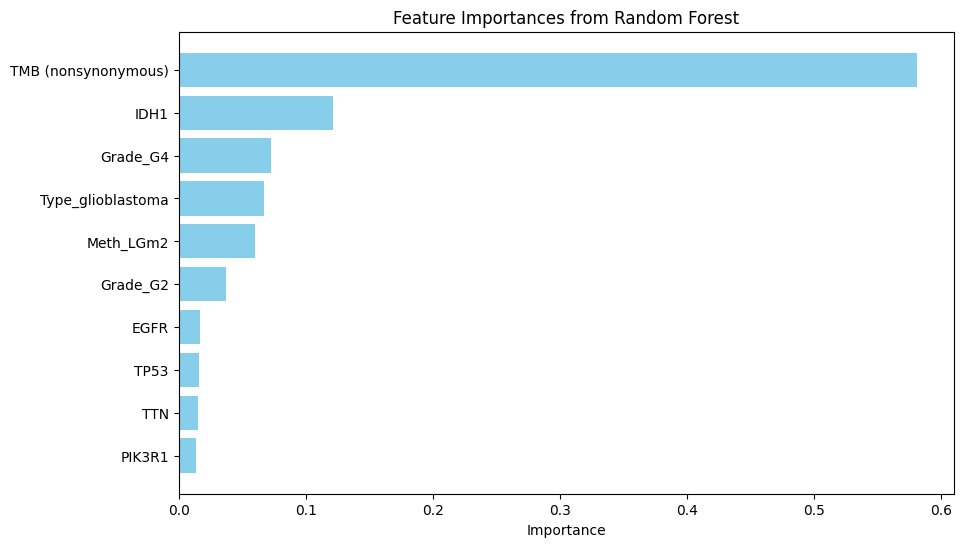

In [74]:
# Access models directly from the ensemble
rf_model = ensemble_model5.named_estimators_['randomforest']
lr_model = ensemble_model5.named_estimators_['logreg']
ada_model = ensemble_model5.named_estimators_['adaboost']
svm_model = ensemble_model5.named_estimators_['svm']
knn_model = ensemble_model5.named_estimators_['knn']

# Extract feature importances from the Random Forest model in the ensemble
rf_model = ensemble_model5.named_estimators_['randomforest']
rf_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Random Forest Feature Importances:")
print(rf_importances)

# Plot feature importances for Random Forest
plt.figure(figsize=(10, 6))
plt.barh(rf_importances['Feature'], rf_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

Logistic Regression Coefficients:
               Feature  Coefficient
4  TMB (nonsynonymous)     0.521614
6             Grade_G4     0.454416
8    Type_glioblastoma     0.454416
2                 EGFR     0.250894
9                 TP53    -0.390857
7            Meth_LGm2    -0.445784
5             Grade_G2    -0.783539
1                  TTN    -0.821725
0                 IDH1    -0.985200
3               PIK3R1    -1.096116


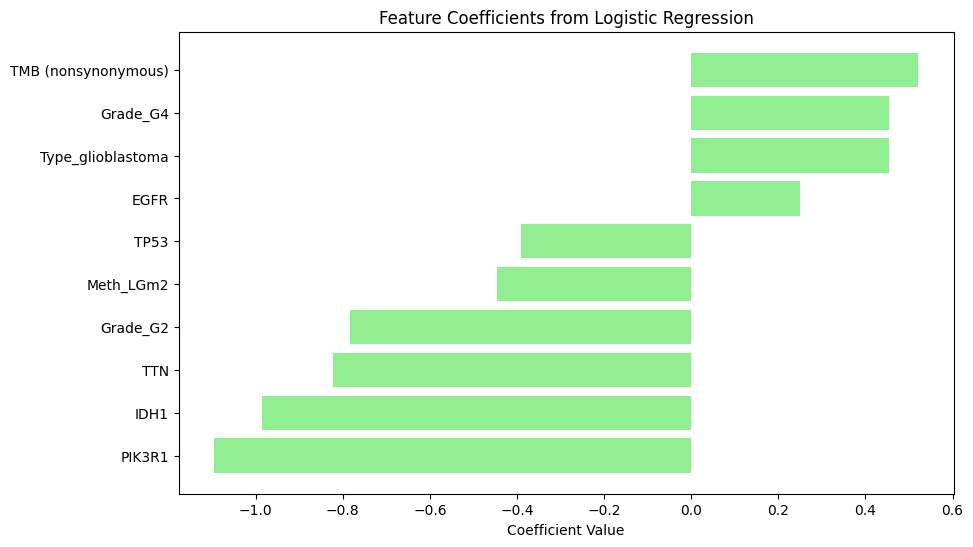

In [75]:
# Extract feature coefficients from Logistic Regression
lr_model = ensemble_model5.named_estimators_['logreg']
lr_importances = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("Logistic Regression Coefficients:")
print(lr_importances)

# Plot coefficients for Logistic Regression
plt.figure(figsize=(10, 6))
plt.barh(lr_importances['Feature'], lr_importances['Coefficient'], color='lightgreen')
plt.xlabel('Coefficient Value')
plt.title('Feature Coefficients from Logistic Regression')
plt.gca().invert_yaxis()
plt.show()

AdaBoost Feature Importances:
               Feature  Importance
4  TMB (nonsynonymous)    0.316515
8    Type_glioblastoma    0.312957
3               PIK3R1    0.138845
0                 IDH1    0.050820
5             Grade_G2    0.044723
1                  TTN    0.041849
6             Grade_G4    0.034738
7            Meth_LGm2    0.030992
2                 EGFR    0.028561
9                 TP53    0.000000


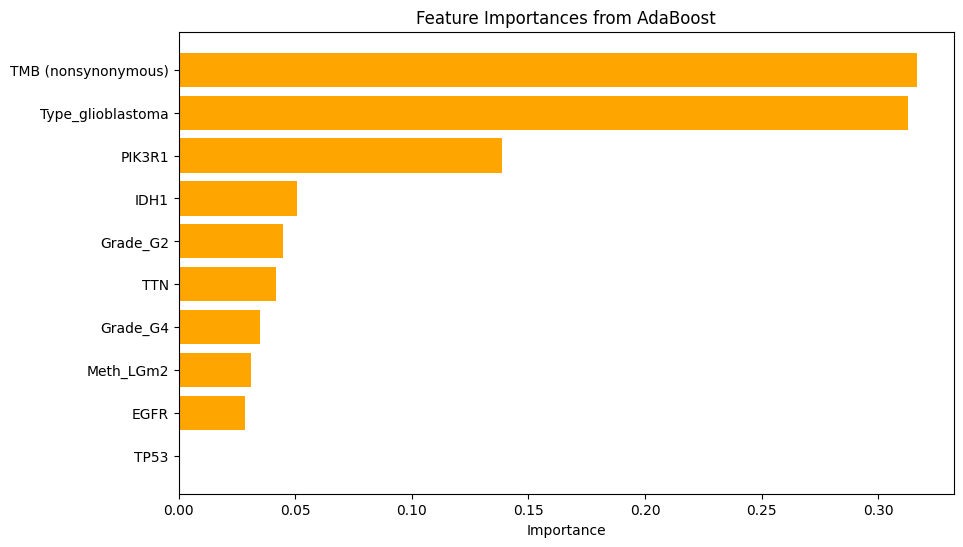

In [76]:
# Extract feature importances from AdaBoost
ada_model = ensemble_model5.named_estimators_['adaboost']
ada_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': ada_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("AdaBoost Feature Importances:")
print(ada_importances)

# Plot feature importances for AdaBoost
plt.figure(figsize=(10, 6))
plt.barh(ada_importances['Feature'], ada_importances['Importance'], color='orange')
plt.xlabel('Importance')
plt.title('Feature Importances from AdaBoost')
plt.gca().invert_yaxis()
plt.show()

KNN Permutation Importances:
               Feature  Importance
0                 IDH1    0.052662
4  TMB (nonsynonymous)    0.039137
1                  TTN    0.009209
2                 EGFR    0.008345
3               PIK3R1    0.008201
5             Grade_G2    0.007482
9                 TP53    0.004173
6             Grade_G4    0.002014
8    Type_glioblastoma    0.002014
7            Meth_LGm2    0.001583


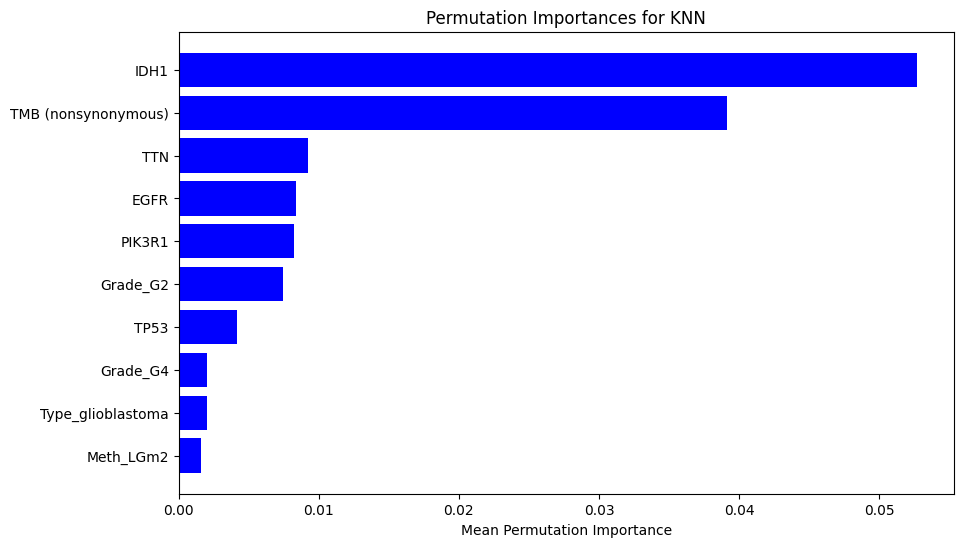

In [77]:
# Calculate permutation importances for KNN
knn_model = ensemble_model5.named_estimators_['knn']
knn_perm_importance = permutation_importance(knn_model, X, y, n_repeats=10, random_state=42)

knn_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': knn_perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

print("KNN Permutation Importances:")
print(knn_importances)

plt.figure(figsize=(10, 6))
plt.barh(knn_importances['Feature'], knn_importances['Importance'], color='blue')
plt.xlabel('Mean Permutation Importance')
plt.title('Permutation Importances for KNN')
plt.gca().invert_yaxis()
plt.show()

SVC Permutation Importances:
               Feature  Importance
0                 IDH1    0.069496
5             Grade_G2    0.039568
7            Meth_LGm2    0.020863
3               PIK3R1    0.011511
1                  TTN    0.008058
6             Grade_G4    0.000432
8    Type_glioblastoma    0.000432
2                 EGFR    0.000000
4  TMB (nonsynonymous)    0.000000
9                 TP53   -0.000288


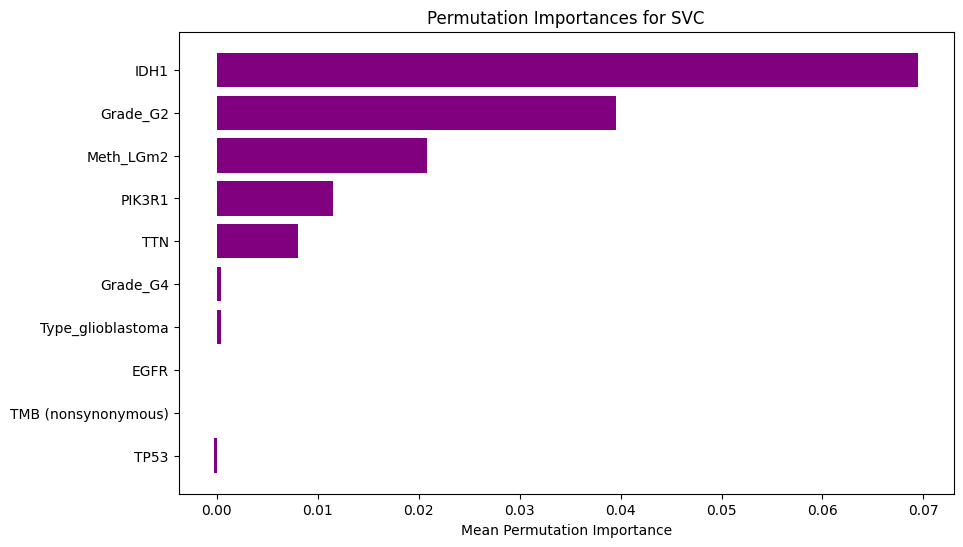

In [78]:
from sklearn.inspection import permutation_importance

# Calculate permutation importances for SVC
svc_model = ensemble_model5.named_estimators_['svm']
svc_perm_importance = permutation_importance(svc_model, X, y, n_repeats=10, random_state=42)

svc_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': svc_perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

print("SVC Permutation Importances:")
print(svc_importances)

plt.figure(figsize=(10, 6))
plt.barh(svc_importances['Feature'], svc_importances['Importance'], color='purple')
plt.xlabel('Mean Permutation Importance')
plt.title('Permutation Importances for SVC')
plt.gca().invert_yaxis()
plt.show()

### Random Survival Forest in sksurv
Usage:
RSF predicts survival probabilities or cumulative hazard functions over time. The library supports metrics like Concordance Index (C- Index) to evaluate model performance.

Key Methods:

fit(X, y): Fits the RSF model.

predict(X): Predicts survival times for new samples.

predict_survival_function(X): Predicts the survival function for each sample.

predict_cumulative_hazard_function(X): Predicts the cumulative hazard function for each sample.

Handles non-linear relationships and high-dimensional data effectively.
Robust to missing data.
Directly models survival probabilities.

The Concordance Index (C-Index) is a metric commonly used to evaluate survival models, including Random Survival Forest (RSF). It measures how well the predicted survival times or risks align with the actual observed survival outcomes.

How C-Index Works:

It compares pairs of individuals to check if the model correctly ranks their survival risks or times.

For two individuals 𝑖  and 𝑗:

If
𝑖 has a shorter observed survival time (𝑇𝑖<𝑇𝑗) and 𝑖 experiences the event earlier, the model should predict a higher risk for 𝑖 (or a shorter survival time).
The pair is concordant if this ranking is correct.
The pair is discordant if the model's prediction contradicts the observed outcome.

Formula:
**C-Index =
Number of Concordant Pairs/Total Number of Comparable Pairs**

Concordant Pair: Predicted survival aligns with the observed survival.

Comparable Pair: Pairs where at least one individual experienced the event.

Good vs. Poor Models:

C-Index Value	Interpretation

0.90–1.00	Excellent predictive ability

0.80–0.89	Good predictive ability

0.70–0.79	Acceptable predictive ability

0.50–0.69	Poor predictive ability (needs improvement)

< 0.50	Model is performing worse than random guessing (likely an implementation error).

We use the same dataset and apply RSF algorithm to predict the survival and also estimate feature importance.


Concordance Index on Test Set: 0.7953


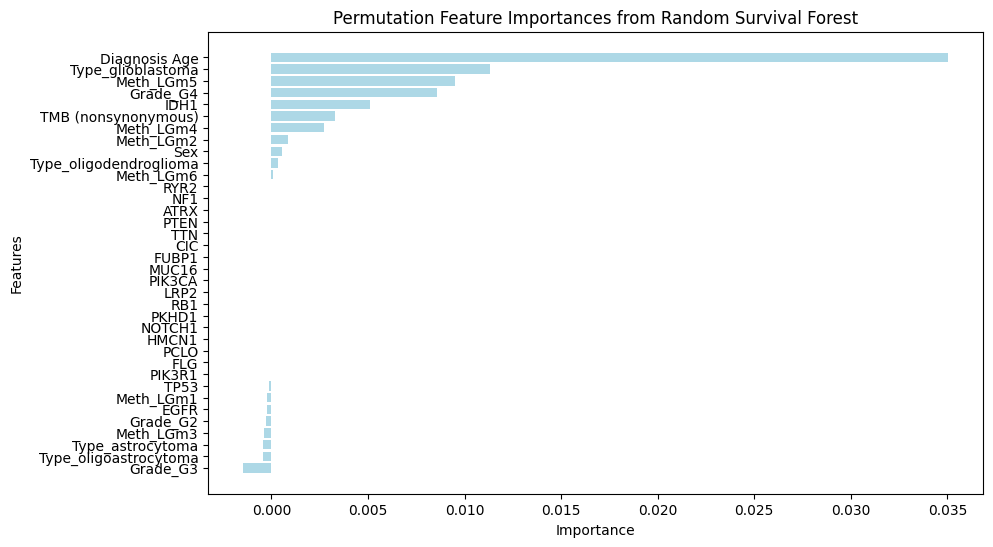

In [79]:
# Prepare the dataset
data = prediction.copy()

# Create feature matrix (X) and target variable (y)
X = data.drop(columns=['Patient ID', 'Overall Survival (Months)', 'Overall Survival Status'])
y = Surv.from_dataframe("Overall Survival Status", "Overall Survival (Months)", data)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize the feature matrix
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Random Survival Forest
rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=10, min_samples_leaf=15, random_state=42)
rsf.fit(X_train_scaled, y_train)

# Validate the model using the test set
c_index = concordance_index_censored(y_test['Overall Survival Status'], y_test['Overall Survival (Months)'], rsf.predict(X_test_scaled))
print(f"Concordance Index on Test Set: {c_index[0]:.4f}")

# Calculate permutation importance on the test set
perm_importance = permutation_importance(rsf, X_test_scaled, y_test, n_repeats=30, random_state=42, n_jobs=-1)

# Extract feature importances and plot them
feature_importances = perm_importance.importances_mean
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='lightblue')
plt.gca().invert_yaxis()  # Show the most important features at the top
plt.title('Permutation Feature Importances from Random Survival Forest')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

Indeed, age at diagnosis is the main feature. We should be able to improve model performance by dropping features that don't have importance to reduce noise.

In [80]:
# Identify features with negative or zero permutation importance
features_to_remove = importance_df[importance_df['Importance'] <= 0]['Feature'].tolist()

# Print features removed
print("Features removed due to negative or zero importance:")
print(features_to_remove)

# Create a list of features that are retained
features_retained = [feature for feature in X.columns if feature not in features_to_remove]
print("\nFeatures retained:")
print(features_retained)

# Drop removed features from the dataset
X_reduced = X[features_retained]

# Split the reduced dataset into training and testing sets
X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42)

# Normalize the feature matrix
X_train_reduced_scaled = scaler.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler.transform(X_test_reduced)

# Train the Random Survival Forest on the reduced feature set
rsf_reduced = RandomSurvivalForest(n_estimators=100, min_samples_split=10, min_samples_leaf=15, random_state=42)
rsf_reduced.fit(X_train_reduced_scaled, y_train)

# Validate the model on the reduced test set
c_index_reduced = concordance_index_censored(
    y_test['Overall Survival Status'], y_test['Overall Survival (Months)'], rsf_reduced.predict(X_test_reduced_scaled)
)
print(f"\nConcordance Index on Reduced Test Set: {c_index_reduced[0]:.4f}")


Features removed due to negative or zero importance:
['RYR2', 'NF1', 'ATRX', 'PTEN', 'TTN', 'CIC', 'FUBP1', 'MUC16', 'PIK3CA', 'LRP2', 'RB1', 'PKHD1', 'NOTCH1', 'HMCN1', 'PCLO', 'FLG', 'PIK3R1', 'TP53', 'Meth_LGm1', 'EGFR', 'Grade_G2', 'Meth_LGm3', 'Type_astrocytoma', 'Type_oligoastrocytoma', 'Grade_G3']

Features retained:
['IDH1', 'Diagnosis Age', 'Sex', 'TMB (nonsynonymous)', 'Grade_G4', 'Meth_LGm2', 'Meth_LGm4', 'Meth_LGm5', 'Meth_LGm6', 'Type_glioblastoma', 'Type_oligodendroglioma']

Concordance Index on Reduced Test Set: 0.8024


The improvement is very very slight though.